In [1]:
import torch

In [2]:
import numpy as np
import os
import pandas as pd
import seaborn as sns
import pickle

import scipy.io as sio
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
from scipy import interpolate
import scipy

import matplotlib.pyplot as plt
from matplotlib import pylab
from pylab import *
from matplotlib.pyplot import show 
import matplotlib.ticker as ticker
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.widgets import TextBox
import matplotlib.cm as cm
import matplotlib.image as mpimg 
import matplotlib.colors

In [3]:
## set personal saving/ retrieving configuration
# define where emg recording is retrieved from (matlab file)
location_mat_file='/Volumes/Extreme_SSD/Projectome_Estimation/filtered_objects/RCPoints_MR012_subset.mat'
## Set subject and lead position
subject='MR012'
lead='GO2'

#define location where plots should be saved
location_save_plots=f'Volumes/Extreme_SSD/Projectome_finder/plots/{subject}/'
os.makedirs(location_save_plots,exist_ok=True)
## if a new dataset should be loaded else dataset will be retrieved
#define location where data should be saved
location_data_dump=f'/Volumes/Extreme_SSD/Projectome_finder/CSV_and_pickle/{subject}/'
os.makedirs(location_data_dump,exist_ok=True)
# set to 1
load_data=0


## Plotting
save_plot=0 # set to 1 to automatically save all the plots
#define location where plots should be saved
# location_save_plots=f'Volumes/Extreme_SSD/Projectome_finder/plots/{subject}/'
location_save_plots=f'/Users/nealarohner/Desktop/Projectome_Finder/code/Neala_Master_Thesis/plots/{subject}/'
os.makedirs(location_save_plots,exist_ok=True)

In [4]:
roots=0, 
electrodes_from_listing=0

In [5]:
df_electrodes_for_roots=pd.read_csv(location_data_dump+'df_electrodes_for_roots.csv')
electrodes_from_listing=list(df_electrodes_for_roots["electrode_name"])
   

In [6]:

def save_figure(folder_name, data_file,location_save_plots=location_save_plots ):
    """
    A function to get the number for the heatmap by by taking the  electric current at the point where afferent recruitment reaches 100%.
    
    Parameters
    ----------
    folder_name
        which folder should it be saved to? eg. recruitment/roots
    data_file
        name of plot
    location_save_plots
        location where plots should be save, set in the beginning
    """
    data_folder = location_save_plots
    save_folder = os.path.join(data_folder,folder_name)
    os.makedirs(save_folder,exist_ok=True)
    data_file_path = os.path.join(save_folder,data_file)
    plt.savefig(data_file_path, transparent = "False",  
    facecolor='w', 
    bbox_inches='tight'
            )

# Muscles

## Load new data and create a tensor

### Loading an RC from Matlab into Python
We load a previously saved RCpoints from Matlab into point for later manipulation as tensor.

**structure of a RCPoint**
* Lead -> implanted lead
* Position -> repositioning ID from during surgery
* Electrode -> 0-based electrode numbering
* Amp -> stimulation amp
* EMGs_filt -> filtered EMG responses
* NormConsts -> normalization constants that were used based on maximal responses
* muscle -> median of peak-to-peak of responses (real value if only one pulse at this amplitude)
* muscle_all -> all peak-to-peaks for the responses at same amplitude

In [7]:
#%matplotlib inline

Loading the file

In [8]:
if load_data:
    mat_contents = sio.loadmat(location_mat_file,squeeze_me=True)
    print(type(mat_contents['subsetRC']))
    subset_array=mat_contents['subsetRC']
    n_cells=len(subset_array)

    # Cells are trials
    n_trials=n_cells

    # We load 1 cell and go all the way to get the key names.
    i_cell = 0 
    cell_i=subset_array[i_cell]
    keys_cell_i = cell_i.dtype.names
    print("keys_cell_i",keys_cell_i)
    n_keys_cell_i=len(keys_cell_i)
    print("n_keys_cell_i",n_keys_cell_i)

In [9]:
if load_data:    
    # Let's declare the keys independently so that it becomes easier to go through them
    key_lead=keys_cell_i[0]
    key_position=keys_cell_i[1]
    key_electrode=keys_cell_i[2]
    key_amplitude=keys_cell_i[3]
    key_emg_time_series=keys_cell_i[4]
    key_normalization_constants_list=keys_cell_i[5]
    indices_median_peak2peak=np.arange(6,38,2)
    indices_median_peak2peak=indices_median_peak2peak.astype(int)
    keys_median_peak2peak_muscle=[keys_cell_i[index] for index in indices_median_peak2peak]
    indices_all_peak2peak=np.arange(7,39,2)
    indices_all_peak2peak=indices_all_peak2peak.astype(int)
    keys_all_peak2peak_muscle=[keys_cell_i[index] for index in indices_all_peak2peak]
    indices_movements_peak2peak=np.arange(38,46,1)
    indices_movements_peak2peak=indices_movements_peak2peak.astype(int)
    keys_movements_peak2peak_muscle=[keys_cell_i[index] for index in indices_movements_peak2peak]
    n_movements_peak2peak_muscle=len(keys_movements_peak2peak_muscle)

In [10]:
if load_data:
    # Now let's open up a EMG time serie struct array and take the keys
    emg_filt_time_series_cell_i=cell_i[key_emg_time_series].item()
    keys_emg_filt_time_serie_cell_i = emg_filt_time_series_cell_i.dtype.names
    print("keys_emg_filt_time_serie_cell_i",keys_emg_filt_time_serie_cell_i)
    n_keys_emg_filt_time_serie_cell_i=len(keys_emg_filt_time_serie_cell_i)
    print("n_keys_emg_filt_time_serie_cell_i",n_keys_emg_filt_time_serie_cell_i)

    # Now let's open up a normalization constants serie struct array and take the keys
    normalization_constants_list_cell_i=cell_i[key_normalization_constants_list].item()
    keys_normalization_constants_list_cell_i = normalization_constants_list_cell_i.dtype.names
    print("keys_normalization_constants_list_cell_i",keys_normalization_constants_list_cell_i)
    n_keys_normalization_constants_list_cell_i=len(keys_normalization_constants_list_cell_i)
    print("n_keys_emg_filt_time_serie_cell_i",n_keys_normalization_constants_list_cell_i)

The keys from the EMG filt time serie, the list of the normalization constants and the keys_median_peak2peak_muscle seem to be the list of muscles (16 muscles) and they are identical. The keys_all_peak2peak_muscle have an \_all appendend to each muscle name.

In [11]:
if load_data:
    # Getting a specific EMG filt time serie
    j_muscle_EMG_filt_time_serie_cell_i=0
    key_muscle_j_EMG_filt_time_serie_cell_i=keys_emg_filt_time_serie_cell_i[j_muscle_EMG_filt_time_serie_cell_i]
    print("key_muscle_j_EMG_filt_time_serie_cell_i",key_muscle_j_EMG_filt_time_serie_cell_i)
    muscle_j_EMG_filt_time_serie_cell_i=emg_filt_time_series_cell_i[key_muscle_j_EMG_filt_time_serie_cell_i].item()

In [12]:
if load_data:
    lead_cell_i=cell_i[key_lead].item()
    position_cell_i=cell_i[key_position].item()
    electrode_cell_i=cell_i[key_electrode].item()
    amplitude_cell_i=cell_i[key_amplitude].item()
    key_muscle_j_EMG_filt_time_serie_cell_i=key_muscle_j_EMG_filt_time_serie_cell_i
    normalization_constant_muscle_j_cell_i=normalization_constants_list_cell_i[key_muscle_j_EMG_filt_time_serie_cell_i].item()
    title_string=lead_cell_i+' - Position: '+str(position_cell_i)+' - Electrode: '+str(electrode_cell_i)+' - Amplitude: '+str(amplitude_cell_i)
    label_string="Muscle "+key_muscle_j_EMG_filt_time_serie_cell_i+' - normalized with:'+"{:10.2f}".format(normalization_constant_muscle_j_cell_i)
    fig = plt.figure(figsize=(7,7))
    plt.plot(muscle_j_EMG_filt_time_serie_cell_i,label=label_string)
    plt.legend()
    plt.xlabel("Timepoint")
    plt.ylabel("Filtered EMG")
    plt.title(title_string)
    plt.grid()
    plt.show

In [13]:
if load_data:
    # Getting the peak to peak saved values for all muscles
    median_peak2peak_muscles_cell_i=cell_i[keys_median_peak2peak_muscle]
    median_peak2peak_muscle_j_cell_i=median_peak2peak_muscles_cell_i[key_muscle_j_EMG_filt_time_serie_cell_i].item()

    # Getting the all peak to peak for this particular muscle
    key_muscle_j_EMG_filt_time_serie_cell_i_all=key_muscle_j_EMG_filt_time_serie_cell_i+"_all"
    all_peak2peak_muscles_cell_i=cell_i[keys_all_peak2peak_muscle]
    all_peak2peak_muscle_j_cell_i=all_peak2peak_muscles_cell_i[key_muscle_j_EMG_filt_time_serie_cell_i_all].item()

    # For the movements let us keep them everywhere since we have little info about them so far
    movements_peak2peak_muscle_cell_i=cell_i[keys_movements_peak2peak_muscle]
    for k_movement in range(n_movements_peak2peak_muscle):
        key_movement_k_peak2peak_cell_i=keys_movements_peak2peak_muscle[k_movement]
        movement_k_peak2peak_cell_i=movements_peak2peak_muscle_cell_i[key_movement_k_peak2peak_cell_i].item()
        print(key_movement_k_peak2peak_cell_i,movement_k_peak2peak_cell_i)

### Data frame construction

Now let us build a dataframe with all the data for later processing.

In [14]:
if load_data:
    verbose=1
    subject = 'MR012'
    n_rows_to_display = 5
    pd.set_option('display.max_rows', n_rows_to_display)
    print(f"n_keys_emg_filt_time_serie_cell_i: {n_keys_emg_filt_time_serie_cell_i}")

In [15]:
if load_data:
    list_elec_config_dfs = []
    if verbose:
        print("Loading data of subject:",subject)
    for i_cell in range(n_cells):
        if verbose:
            print("Loading cell: ",i_cell)
        cell_i=subset_array[i_cell]
        keys_cell_i = cell_i.dtype.names
        if verbose>2:
            print("keys_cell_i",keys_cell_i)
        n_keys_cell_i=len(keys_cell_i)
        if verbose>2:
            print("n_keys_cell_i",n_keys_cell_i)
        # Getting the info with the previously extracted keys
        lead_cell_i=cell_i[key_lead].item()
        position_cell_i=cell_i[key_position].item()
        electrode_cell_i=cell_i[key_electrode].item()
        amplitude_cell_i=cell_i[key_amplitude].item()
        # Lists
        median_peak2peak_muscles_cell_i=cell_i[keys_median_peak2peak_muscle]
        all_peak2peak_muscles_cell_i=cell_i[keys_all_peak2peak_muscle]
        movements_peak2peak_muscle_cell_i=cell_i[keys_movements_peak2peak_muscle]
        # Structured arrays with arrays inside
        emg_filt_time_series_cell_i=cell_i[key_emg_time_series].item()
        normalization_constants_list_cell_i=cell_i[key_normalization_constants_list].item()
        # Getting time series
        for j_muscle_EMG_filt_time_serie_cell_i in range(n_keys_emg_filt_time_serie_cell_i):
            key_muscle_j_EMG_filt_time_serie_cell_i=keys_emg_filt_time_serie_cell_i[j_muscle_EMG_filt_time_serie_cell_i]
            key_muscle_j_EMG_filt_time_serie_cell_i_all=key_muscle_j_EMG_filt_time_serie_cell_i+"_all"
            median_peak2peak_muscle_j_cell_i=median_peak2peak_muscles_cell_i[key_muscle_j_EMG_filt_time_serie_cell_i].item()
            all_peak2peak_muscle_j_cell_i=all_peak2peak_muscles_cell_i[key_muscle_j_EMG_filt_time_serie_cell_i_all].item()
            # if verbose: 
            #     print("Muscle",key_muscle_j_EMG_filt_time_serie_cell_i)
            muscle_j_EMG_filt_time_serie_cell_i=emg_filt_time_series_cell_i[key_muscle_j_EMG_filt_time_serie_cell_i].item()
            n_time_points_trial=len(muscle_j_EMG_filt_time_serie_cell_i)
            if n_time_points_trial!=1000:
                print(key_muscle_j_EMG_filt_time_serie_cell_i,n_time_points_trial )
            
            normalization_constant_muscle_j_cell_i=normalization_constants_list_cell_i[key_muscle_j_EMG_filt_time_serie_cell_i].item()
            # Creating the dataframe
            df_trial_muscle_and_other_i_data = pd.DataFrame(data=[[muscle_j_EMG_filt_time_serie_cell_i]],columns=[key_emg_time_series])
            df_trial_muscle_and_other_i_data['Time_points'] = n_time_points_trial
            df_trial_muscle_and_other_i_data['Muscle'] = key_muscle_j_EMG_filt_time_serie_cell_i
            df_trial_muscle_and_other_i_data['Elec_config'] = electrode_cell_i
            df_trial_muscle_and_other_i_data['Subject'] = subject
            df_trial_muscle_and_other_i_data['Amplitudes'] = amplitude_cell_i
            df_trial_muscle_and_other_i_data['Lead'] = lead_cell_i
            df_trial_muscle_and_other_i_data['Position'] = position_cell_i
            df_trial_muscle_and_other_i_data['Normalization_Constant'] = normalization_constant_muscle_j_cell_i
            df_trial_muscle_and_other_i_data['Median_Peak2Peak'] = median_peak2peak_muscle_j_cell_i
            df_trial_muscle_and_other_i_data['All_Peak2Peak'] = [all_peak2peak_muscle_j_cell_i]
            # filling the movements
            for k_movement in range(n_movements_peak2peak_muscle):
                key_movement_k_peak2peak_cell_i=keys_movements_peak2peak_muscle[k_movement]
                movement_k_peak2peak_cell_i=movements_peak2peak_muscle_cell_i[key_movement_k_peak2peak_cell_i].item()
                df_trial_muscle_and_other_i_data[key_movement_k_peak2peak_cell_i] = movement_k_peak2peak_cell_i
                if verbose>1:
                    print(key_movement_k_peak2peak_cell_i,movement_k_peak2peak_cell_i)
            list_elec_config_dfs.append(df_trial_muscle_and_other_i_data)
    if len(list_elec_config_dfs)>0:
        df_subject = pd.concat(list_elec_config_dfs, ignore_index=True)
        df_subject.reset_index(inplace=True)  


In [16]:
if load_data:
    print(df_subject)

### Save the df

In [17]:
if load_data:
    mt_electrodes=pd.DataFrame(df_subject['Elec_config'].unique(), columns=["elec_name"])  #Elec01_, Elec02_, Elec03_, 
    mt_muscles=pd.DataFrame(df_subject['Muscle'].unique(), columns=["muscle_name"]) #LVlat, LST, ..
    unique_amplitudes=pd.DataFrame(df_subject['Amplitudes'].unique(), columns=["amplitude_name"])
    

    
    mt_electrodes.to_csv(location_data_dump+'mt_electrodes.csv')
    mt_muscles.to_csv(location_data_dump+'mt_muscles.csv')
    unique_amplitudes.to_csv(location_data_dump+'unique_amplitudes.csv')
    df_subject.to_csv(location_data_dump+'df_subject.csv')



### Create tensor

In [18]:
#device =  "cuda" if torch.cuda.is_available() else "cpu"

Max reps evt not used in the future, better to take the mean already, but also think on how to make it automatic

In [19]:

# def unique(list1):
#     x = np.array(list1)
#     print(np.unique(x))

# max_reps=unique(max(reps))


#### Create filtered data tensor

Manually adjustable if tensors should be created

In [20]:
create_tensor=load_data

In [21]:
#electrodes
#muscles
#amplitudes
#max_reps
#filtered EMG
if create_tensor:
    max_reps=39 # see notebook 6
    time_points=1000

    filtered_data_to_tensor=torch.ones(len(mt_electrodes['elec_name']),len(mt_muscles['muscle_name']),len(unique_amplitudes),max_reps,time_points)
    filtered_data_to_tensor.size()

In [22]:
## make it work with df
if create_tensor:
    for elec_i in range (len(mt_electrodes['elec_name'])) : #loop through all the elecs
        for muscle_i in range (len(mt_muscles['muscle_name'])): # loop through all the muscles
            amp_index=0
            data_amp_index=0
            print(f"elec: {elec_i} muscle:{muscle_i}")
            for amp_in_unique_amp in unique_amplitudes: # loop through all the amplitudes
                print("#####################################################")
                print(f"searching for data for amplitude {amp_in_unique_amp}")
                reps=0

                #compare length, in order to stop after max amplitude of a combiantion
                if data_amp_index < len(df_subject[(df_subject["Elec_config"]==elec_i)&(df_subject["Muscle"]== mt_muscles['muscle_name'][muscle_i] )]["Amplitudes"]): 
                    #Check for which amplitudes there is data
                    print("passed checkpoint, now check if aplitudes match")
                    data_amp=round(df_subject[(df_subject["Elec_config"]==elec_i)&(df_subject["Muscle"]== mt_muscles['muscle_name'][muscle_i] )].reset_index().iloc[data_amp_index]["Amplitudes"], 2)
                    print(f"comparing unique: {amp_in_unique_amp} with data amp: {data_amp}")
                    if data_amp==amp_in_unique_amp:                        
                        #Fill the single reps with data
                        print("found a suiting amplitude")
                        print("Now how many reps")
                        checking_reps=df_subject[(df_subject["Elec_config"]==elec_i)&(df_subject["Muscle"]== mt_muscles['muscle_name'][muscle_i] )&(round(df_subject["Amplitudes"],2)== data_amp )]["Time_points"].item()

                        if checking_reps==1000:
                            print("only one trial")
                            # Fill data
                            filtered_data_to_tensor[elec_i, muscle_i, amp_index,reps,:]=torch.tensor(df_subject[(df_subject["Elec_config"]==elec_i)&(df_subject["Muscle"]== mt_muscles['muscle_name'][muscle_i])&(round(df_subject["Amplitudes"], 2)== amp_in_unique_amp)]["EMGs_filt"].item())
                            # Fill left over with nan values
                            reps+=1 
                            filtered_data_to_tensor[elec_i, muscle_i, amp_index,reps:,:]=torch.zeros((len(filtered_data_to_tensor[elec_i, muscle_i, amp_index,reps:,0]),time_points)).float()
                            filtered_data_to_tensor[filtered_data_to_tensor==0]= float('nan') #didn't find torch.nan function
                        #Fill the multiple reps with data
                        else:
                            while reps<checking_reps:
                                print("going through the while loop")
                                print(" fill data")
                                filtered_data_to_tensor[elec_i, muscle_i, amp_index,reps,:]=torch.tensor(df_subject[(df_subject["Elec_config"]==elec_i)&(df_subject["Muscle"]== mt_muscles['muscle_name'][muscle_i])&(round(df_subject["Amplitudes"], 2)== amp_in_unique_amp)]["EMGs_filt"].item()[reps])
                                reps+=1

                            # Fill left over reps with nan
                            else: 
                                print("finished the while loop")
                                if checking_reps<max_reps:
                                    filtered_data_to_tensor[elec_i, muscle_i, amp_index,reps:,:]=torch.zeros((len(filtered_data_to_tensor[elec_i, muscle_i, amp_index,reps:,0]),time_points)).float()
                                    filtered_data_to_tensor[filtered_data_to_tensor==0]= float('nan') #didn't find torch.nan function
                        
                        #increase the amplitude index by one
                        data_amp_index+=1
                        
                    #Fill the amplitudes without data with 'nan'
                    else:
                        print(f"No match for {amp_in_unique_amp} fill with nan")
                        filtered_data_to_tensor[elec_i, muscle_i, amp_index,:,:]=torch.zeros((max_reps,time_points)).float()
                        filtered_data_to_tensor[filtered_data_to_tensor==0]= float('nan') #didn't find torch.nan function
                    
                    #increase the amplitude index by one
                    amp_index+=1 

                else:
                    print(f"No more data for this combination  fill all with nan")
                    filtered_data_to_tensor[elec_i, muscle_i, amp_index,:,:]=torch.zeros((max_reps,time_points)).float()
                    filtered_data_to_tensor[filtered_data_to_tensor==0]= float('nan') #didn't find torch.nan function
                
    
  

#### Create peak to peak values tensor

In [23]:
#electrodes
#muscles
#amplitudes
#max_reps
#peak to peak value
if create_tensor:
    max_reps=39 # see notebook 6
    peak_to_peak_value=1


    peak2peak_data_to_tensor=torch.ones(len(mt_electrodes['elec_name']),len(mt_muscles['muscle_name']),len(unique_amplitudes),max_reps,peak_to_peak_value)
    peak2peak_data_to_tensor.size()

In [24]:

## make it work with df
if create_tensor:
    for elec_i in range (len(mt_electrodes['elec_name'])) : #loop through all the elecs
        for muscle_i in range (len(mt_muscles['muscle_name'])): # loop through all the muscles
            amp_index=0
            data_amp_index=0
            print(f" Data search for muscle: {muscle_i} and elec: {elec_i}")
            for amp_in_unique_amp in unique_amplitudes: # loop through all the amplitudes
                print("#####################################################")
                print(f"starting data search, for amp: {amp_in_unique_amp} ")
                reps=0
                # make sure loop doesnt exceed lenght of data, to evade error
                if  data_amp_index< len(df_subject[(df_subject["Elec_config"]==elec_i)&(df_subject["Muscle"]== mt_muscles['muscle_name'][muscle_i] )]["Amplitudes"]): 
                    print("passed checkpoint")
                    
                    #Check for which amplitudes there is data
                    data_amp=round(df_subject[(df_subject["Elec_config"]==elec_i)&(df_subject["Muscle"]== mt_muscles['muscle_name'][muscle_i] )].reset_index().iloc[data_amp_index]["Amplitudes"], 2)
                    print(f"comparing unique: {amp_in_unique_amp} with data amp: {data_amp}")
                    if data_amp==amp_in_unique_amp:
                        print("found a suiting amplitude")
                        
                        # fill meadian peak to peak value for that amplitude
                        print(f"Only one Rep, thus reps must be zero :{reps} ")
                        peak2peak_data_to_tensor[elec_i, muscle_i, amp_index,reps,:]=torch.tensor(df_subject[(df_subject["Elec_config"]==elec_i)&(df_subject["Muscle"]== mt_muscles['muscle_name'][muscle_i])&(round(df_subject["Amplitudes"], 2)== amp_in_unique_amp)]["Median_Peak2Peak"].item())
                        reps+=1
                        peak2peak_data_to_tensor[elec_i, muscle_i, amp_index,reps:,:]=torch.zeros((len(peak2peak_data_to_tensor[elec_i, muscle_i, amp_index,reps:,0]),peak_to_peak_value)).float()
                        peak2peak_data_to_tensor[peak2peak_data_to_tensor==0]= float('nan') #didn't find torch.nan function
                    
                        
                            
                         
                    else:
                        print("there is no data thus tensor filled with nan")
                        peak2peak_data_to_tensor[elec_i, muscle_i, amp_index,:,:]=torch.zeros(( max_reps,peak_to_peak_value)).float()
                        peak2peak_data_to_tensor[peak2peak_data_to_tensor==0]= float('nan') #didn't find torch.nan function
                        print(f"pritning tensor slice for elec: {elec_i}, muscle:{muscle_i} and amp: {amp_in_unique_amp}")
                    
                    
                # Fill left over data with nan
                else:
                    #Fill  amplitude the with  nan
                    print(f"no more data for elec: {elec_i}, muscle:{muscle_i}")
                    peak2peak_data_to_tensor[elec_i, muscle_i, amp_index,:,:]=torch.zeros((max_reps,peak_to_peak_value)).float()
                    peak2peak_data_to_tensor[peak2peak_data_to_tensor==0]= float('nan') #didn't find torch.nan function
                
                amp_index+=1

#### Create amplitude tensor 

In [25]:
if create_tensor:
    ### Create tensor with size torch.Size([16, 14, 32]) 
    # nMuslces x nElecs x nAmp_unique 
    amplitude_filtereddata_to_tensor=torch.ones(len(mt_electrodes['elec_name']),len(mt_muscles['muscle_name']),len(unique_amplitudes))
    amplitude_filtereddata_to_tensor.size()

In [26]:
##  working  with df :D
if create_tensor:
    ## Starting with elec 0, muslce 0, amp=0.5, filling the 10rows (repetition) for the spec. amp with the raw data/ resp nan value since there is no data for that amplitude
    for elec_i in range (len(mt_electrodes['elec_name'])) : #loop through all the elecs
        for muscle_i in range(len(mt_muscles['muscle_name'])): # loop through all the muscles
                
            ind=0 # set index to zero, will serve as index from amplitudes
            for pos_in_unique_amplitudes in range(len(unique_amplitudes)): #loop through all the amplitudes possible
                

                if len(df_subject[(df_subject["Elec_config"]==elec_i)&(df_subject["Muscle"]== mt_muscles['muscle_name'][muscle_i] )]["Amplitudes"]) > ind: #Make sure not to exceed size of amplitude count
                    data_amp=round(df_subject[(df_subject["Elec_config"]==elec_i)&(df_subject["Muscle"]== mt_muscles['muscle_name'][muscle_i] )].reset_index().iloc[ind]["Amplitudes"], 2)


                    print(f"Amplitude of unique amp:{unique_amplitudes[pos_in_unique_amplitudes]}, {elec_i}, {mt_muscles['muscle_name'][muscle_i]},  data_amp:{data_amp}")

                    if data_amp > unique_amplitudes[pos_in_unique_amplitudes]:
                        print(f"No data for Amplitude: {unique_amplitudes[pos_in_unique_amplitudes]}, next amp with data: {data_amp} fill  nan for this amplitude")
                        amplitude_filtereddata_to_tensor[elec_i, muscle_i, pos_in_unique_amplitudes]=torch.zeros((1)).float()
                        amplitude_filtereddata_to_tensor[amplitude_filtereddata_to_tensor==0]= float('nan') #didn't find torch.nan function
                        
                    elif data_amp == unique_amplitudes[pos_in_unique_amplitudes]:
                        #save the amp with data
                        print("same amplitude")
                    
                        amplitude_filtereddata_to_tensor[elec_i, muscle_i, pos_in_unique_amplitudes]=torch.Tensor([data_amp])
                        ind+=1
                        print("#################################################################")

                
                else: #No more data for the remaining amplitudes in unique_amplitudes, thus fill with nan
                    print(f"In combination {elec_i}_{mt_muscles['muscle_name'][muscle_i]} no more data for {unique_amplitudes[pos_in_unique_amplitudes]}, nan value for this and following amplitudes")
                    # amplitude_data_to_tensor[elec_i, muscle_i, pos_in_unique_amplitudes:]=torch.zeros((len(unique_amplitudes)-pos_in_unique_amplitudes)).float()
                    amplitude_filtereddata_to_tensor[elec_i, muscle_i, pos_in_unique_amplitudes]=torch.zeros((1)).float()
                    amplitude_filtereddata_to_tensor[amplitude_filtereddata_to_tensor==0]= float('nan') #didn't find torch.nan function


### Save tensor as pickle file

In [27]:
### save files as pickle file  to projectome_finder#
if create_tensor:
 


    file = open(location_data_dump +'robin_data_tensor_dump.pkl', "wb")
    # file = open('/Users/nealarohner/Desktop/Projectome_Finder/code/Neala_Master_Thesis/data/pickle_files/+'robin_data_tensor_dump.pkl', "wb")

    obj_1 = filtered_data_to_tensor #torch.Size([16, 16, 40, 39, 1000])
    obj_2 = amplitude_filtereddata_to_tensor #torch.Size([16, 16, 40])
    obj_3 = peak2peak_data_to_tensor #torch.Size([16, 16, 40, 39, 1])

    pickle.dump(obj_1, file)
    pickle.dump(obj_2, file)
    pickle.dump(obj_3, file)

    file.close()





## to retrieve ##
## file = open('/Users/nealarohner/Desktop/Projectome_Finder/code/Neala_Master_Thesis/data/pickle_files/robin_data_tensor_dump.pkl', 'rb')
# file = open(location_data_dump+'robin_data_tensor_dump.pkl', 'rb')
# filtered_data_to_tensor = pickle.load(file)
# amplitude_filtereddata_to_tensor  = pickle.load(file)
# peak2peak_data_to_tensor = pickle.load(file)

# file.close()

## Retrieve pickle and csv data

In [28]:

if load_data==0:
    file = open(location_data_dump +'robin_data_tensor_dump.pkl', 'rb')
    filtered_data_to_tensor = pickle.load(file)
    amplitude_filtereddata_to_tensor  = pickle.load(file)
    peak2peak_data_to_tensor = pickle.load(file)

    file.close()



In [29]:

if load_data==0:
    # to retrieve ##
    mt_electrodes=pd.read_csv(location_data_dump+'mt_electrodes.csv')
    mt_muscles=pd.read_csv(location_data_dump+'mt_muscles.csv')
    unique_amplitudes=pd.read_csv(location_data_dump + 'unique_amplitudes.csv')

    electrodes=list(mt_electrodes["elec_name"])
    muscles=list(mt_muscles["muscle_name"])
    unique_amplitudes=list(unique_amplitudes["amplitudes"])

In [30]:
muscles_left=['LIL','LRF', 'LVL','LST', 'LTA','LMG','LSOL', 'LPS']
muscles_right=['RIL','RRF', 'RVL','RST', 'RTA','RMG','RSOL', 'RPS']

## Filtered EMG

Plot the raw values,thus for every electrode-muscle combination you have a curve for every amplitude for that combination


In [31]:
def get_raw_emg_per_electrode(filtered_data_to_tensor=filtered_data_to_tensor,amplitude_filtereddata_to_tensor=amplitude_filtereddata_to_tensor, unique_amplitudes=unique_amplitudes, save_fig=0, mt_electrodes=mt_electrodes):
    """
    A function to create recruitment curves by electrode

    Parameters
    ----------
    filtered_data_to_tensor
        EMG data used for the recruitment curve, set by default
    amplitude_filtereddata_to_tensor
        Amplitudes used for the recruitment curve, set by default
    unique_amplitudes
        list with all the amplitudes
    save_fig
        int, if set to 1 save figure
    mt_electrodes
        pandas df, all ellectrodes used in data
    mt_muscles
        pandas df, all muscles used in data


    """

    for elec_i in range (0, len(mt_electrodes[0:1])):
        fig, ax = plt.subplots(figsize=(10,7))
        for muscle_i in range (len(mt_muscles[0:1])):
            for amplitude_i in range (0, len(amplitude_filtereddata_to_tensor[elec_i, muscle_i, :])):
                colors = cm.rainbow(np.linspace(0, 1, len(amplitude_filtereddata_to_tensor[elec_i, muscle_i, :])))
                # if no values for that amplitude break for loop
                if np.isnan(np.array(amplitude_filtereddata_to_tensor[elec_i, muscle_i, amplitude_i])):
                    continue
                # Define variables for plotting
                x = np.arange(0, len(filtered_data_to_tensor[elec_i, muscle_i, amplitude_i, 0, :]))
                y = filtered_data_to_tensor[elec_i, muscle_i, amplitude_i, 0, :]
    
                # Plot the data points
                plt.plot(x,  y, '-', c=colors[amplitude_i], label= unique_amplitudes[amplitude_i]) 
                
            plt.legend(title="Amplitude of current [mA]")
            # Set label and scale
            ax.set_xlabel("Timepoints [in 100 ms]") # freq. rate = 10kHz, 1000 time points
            # ax.set_xticks(ticks=np.linspace(start=0.2, stop=np.max(unique_amplitudes)+0.1, endpoint=True, num=25))
            ax.set_ylabel(f"filtered EMG [mV]")
            # ax.set_xticks(ticks=np.linspace(0, 100))

            # Plotting settings
            # ax.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
            ax.set_title(f"Filtered EMG for elec: {elec_i} and muscle: {mt_muscles['muscle_name'][muscle_i]} ")
            
        ## save plots ##
        if save_fig:
            folder_name="Raw_EMG"
            data_file="elec"+"_"+str(elec_i)+"_"+"raw_emg"+'.png'
            save_figure(folder_name, data_file)

            plt.show()
    
       


In [32]:
def get_raw_emg_per_electrode(filtered_data_to_tensor=filtered_data_to_tensor,amplitude_filtereddata_to_tensor=amplitude_filtereddata_to_tensor, unique_amplitudes=unique_amplitudes, save_fig=0, mt_electrodes=mt_electrodes):
    """
    A function to create recruitment curves by electrode

    Parameters
    ----------
    filtered_data_to_tensor
        EMG data used for the recruitment curve, set by default
    amplitude_filtereddata_to_tensor
        Amplitudes used for the recruitment curve, set by default
    unique_amplitudes
        np.array with all the amplitudes
    save_fig
        int, if set to 1 save figure
    mt_electrodes
        pandas df, all ellectrodes used in data
    mt_muscles
        pandas df, all muscles used in data


    """

    for elec_i in range (0, len(mt_electrodes[0:1])):
        fig, ax = plt.subplots(figsize=(10,7))
        for muscle_i in range (len(mt_muscles[0:1])):
            for amplitude_i in range (0, len(amplitude_filtereddata_to_tensor[elec_i, muscle_i, :])):
                colors = cm.rainbow(np.linspace(0, 1, len(amplitude_filtereddata_to_tensor[elec_i, muscle_i, :])))
                # if no values for that amplitude break for loop
                if np.isnan(np.array(amplitude_filtereddata_to_tensor[elec_i, muscle_i, amplitude_i])):
                    continue
                # Define variables for plotting
                x = np.arange(0, len(filtered_data_to_tensor[elec_i, muscle_i, amplitude_i, 0, :]))
                y = filtered_data_to_tensor[elec_i, muscle_i, amplitude_i, 0, :]
    
                # Plot the data points
                plt.plot(x,  y, '-', c=colors[amplitude_i], label= unique_amplitudes[amplitude_i]) 
                
            plt.legend(title="Amplitude of current [mA]")
            # Set label and scale
            ax.set_xlabel("Timepoints [in 100 ms]") # freq. rate = 10kHz, 1000 time points
            # ax.set_xticks(ticks=np.linspace(start=0.2, stop=np.max(unique_amplitudes)+0.1, endpoint=True, num=25))
            ax.set_ylabel(f"filtered EMG [mV]")
            # ax.set_xticks(ticks=np.linspace(0, 100))

            # Plotting settings
            # ax.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
            ax.set_title(f"Filtered EMG for elec: {elec_i} and muscle: {mt_muscles['muscle_name'][muscle_i]} ")
            
        ## save plots ##
        if save_fig:
            folder_name="Raw_EMG"
            data_file="elec"+"_"+str(elec_i)+"_"+"raw_emg"+'.png'
            save_figure(folder_name, data_file)

            plt.show()
    
       


In [33]:
if save_plot:
    get_raw_emg_per_electrode(save_fig=save_plot)


## EMG Processing -Recruitment curves

For the rectuitment curve per electrode, you have one value ( the peak to peak value) per amplitude for the different muscles.

### Recruitment per elec

In [34]:
def get_recruitment_curve_per_electrode(peak2peak_data_to_tensor=peak2peak_data_to_tensor,amplitude_filtereddata_to_tensor=amplitude_filtereddata_to_tensor, unique_amplitudes=unique_amplitudes, save_fig=0, mt_electrodes=mt_electrodes):
    """
    A function to create recruitment curves by electrode

    Parameters
    ----------
    peak2peak_data_to_tensor
        Peak to peak values of EMG data, used for the recruitment curve, set by default
    amplitude_filtereddata_to_tensor
        Amplitudes used for the recruitment curve, set by default
    unique_amplitudes
        np.array with all the amplitudes
    save_fig
        int, if set to 1 save figure
    mt_electrodes
        pandas df, all ellectrodes used in data
    mt_muscles
        pandas df, all muscles used in data


    """

    colors = cm.rainbow(np.linspace(0, 1, len(mt_muscles)))
    label=mt_muscles["muscle_name"]

    for elec_i in range (0, len(mt_electrodes)):
        fig, ax = plt.subplots(figsize=(10,7))
        for muscle_i in range (len(mt_muscles)):

            # Define variables for plotting
            x = amplitude_filtereddata_to_tensor[elec_i,muscle_i,:]
            y = peak2peak_data_to_tensor[elec_i, muscle_i, :, 0, 0]
        
            # Remove nan values
            x_without_nan=np.array(x)
            x_without_nan=x_without_nan[~np.isnan(x_without_nan)]
            y_without_nan=np.array(y)
            y_without_nan=y_without_nan[~np.isnan(y_without_nan)]

            # Plot the data points
            plt.plot(x_without_nan,  y_without_nan, 'o-', c=colors[muscle_i], label= mt_muscles['muscle_name'][muscle_i]) 
            
            # Add text descripiton to the points for visibility
            for index in range (len(x_without_nan)):
                ax.text(x_without_nan[index], y_without_nan[index], label[muscle_i], size=10) 
            
            # Set label and scale
            ax.set_xlabel("Amplitude [mA]")
            ax.set_xticks(ticks=np.linspace(start=0.2, stop=np.max(unique_amplitudes)+0.1, endpoint=True, num=25))
            ax.set_ylabel(f"Peak to peak value [mV]")
            ax.set_yticks(ticks=np.linspace(0, np.nanmax(peak2peak_data_to_tensor [:, :,:, 0, 0]), 11))

        # Plotting settings
        ax.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left', title="muscles")
        ax.set_title(f"Recruitment curve for elec: {elec_i}")

        ## save plots ##
        if save_fig:
            data_file = "elec"+"_"+str(elec_i)+"_"+"recruitment_curve"+'.png'
            folder_name="recruitment_curve/muscles/recruitment_per_elec"
            save_figure(folder_name, data_file)

        plt.show()


In [35]:
if save_plot:
    get_recruitment_curve_per_electrode(save_fig=save_plot)

### Recruitment per muscle 

In [36]:

def get_recruitment_curve_per_muscles(peak2peak_data_to_tensor=peak2peak_data_to_tensor,amplitude_filtereddata_to_tensor=amplitude_filtereddata_to_tensor,unique_amplitudes=unique_amplitudes,  save_fig=0, mt_electrodes=mt_electrodes):
    """
    A function to create recruitment curves by muscle. 

    Parameters
    ----------
    peak2peak_data_to_tensor
        EMG data used for the recruitment curve, set by default
    amplitude_filtereddata_to_tensor
        Amplitudes used for the recruitment curve, set by default
    unique_amplitudes
        np.array with all the amplitudes
    save_fig
        int, if set to 1 save figure
    mt_electrodes
        pandas df, all ellectrodes used in data
    mt_muscles
        pandas df, all muscles used in data


    """
    colors = cm.rainbow(np.linspace(0, 1, len(mt_electrodes)))
    label=mt_electrodes["elec_name"]

    for muscle_i in range (len(mt_muscles)):
        fig, ax = plt.subplots(figsize=(10,7))
        for elec_i in range (0, len(mt_electrodes)):
        
            # Define variables for plotting
            x = amplitude_filtereddata_to_tensor[elec_i,muscle_i,:]
            y = peak2peak_data_to_tensor[elec_i, muscle_i, :, 0, 0]
        
            # Remove nan values for the text index
            x_without_nan=np.array(x)
            x_without_nan=x_without_nan[~np.isnan(x_without_nan)]
            y_without_nan=np.array(y)
            y_without_nan=y_without_nan[~np.isnan(y_without_nan)]

            # Plot the data points
            plt.plot(x_without_nan, y_without_nan, 'o-', c=colors[elec_i],  label=mt_electrodes['elec_name'][elec_i]) 
                
            # Add text descripiton to the points for visibility
            for index in range (len(x_without_nan)):
                ax.text(x_without_nan[index], y_without_nan[index], label[elec_i], size=10) 
            
            # Set label and scale
            ax.set_xlabel("Amplitude [mA]")
            ax.set_xticks(ticks=np.linspace(start=0.2, stop=np.max(unique_amplitudes)+0.1, endpoint=True, num=25))
            ax.set_ylabel(f"Peak to peak value [mV]")
            ax.set_yticks(ticks=np.linspace(0, np.nanmax(peak2peak_data_to_tensor [:, :,:, 0, 0]), 11))

        # Plotting settings
        ax.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left', title= "electrodes")
        ax.set_title(f"Recruitment curve for muscle {mt_muscles['muscle_name'][muscle_i]}")

        ## save plots ##
        if save_fig:
            data_file = mt_muscles['muscle_name'][muscle_i]+"_"+"recruitment_curve"+'.png'
            folder_name="recruitment_curve/muscles/recruitment_per_msc"
            save_figure(folder_name, data_file)


    plt.show()

In [37]:
if save_plot:
    get_recruitment_curve_per_muscles(save_fig=save_plot)


## Muscle recruitment processing

For now there are two possibibilites 

**A: Heatmap**

Since there is an inconsistent sweep of amplitudes between the electrodes (some elctrodes are not stimulating as high as others) it's hard to compare the activation of the muscle between the electrodes and define the electrode(s) that predominantly activate a certain muscle.
Thus here we have different approaches to solve this problem:

Normalisation methods:
- Normalise by amplitude:
    - for peak to peak values: max output(max activation) / input(amp) at max activation
    - for integral (hasn't been done yet): output int /input (amp) bim max 
- Normalise by max value
- Selectivity index (described in paper)(not done yet) (not recommended)


**B: Fit recruitment to sigmoids**

Here the insconsistent sweep is less of an issue, since we are eitherway interpolating the values with our fit.


### A: Heat map

#### Normalisation


##### normalise_max_P2P_div_amp

For every muscle electrode combination the max muscle response is divided by the ampliude at that point. 
However with this method we don't take into account the impedance. There's a big variability between the different electrodes (eg  impedance given by tissue btw elec and return.  eg air bubble etc )
After having done the normalisation by amplitude, there is a problem with the low values for the interpolation: values between 0 and 1 will be rounded to zero. Thus we have to multiply it by 100 before interpolating
and change the plotting scale (vmin, and vmax) to 0 to 100, thus we should get to the same results and in the heatmap without interpolation where data_1 was used, and vmin=0 and vmax=1.


In [38]:
def set_normalisation_max_p2p_div_amp(mt_muscles=mt_muscles,mt_electrodes=mt_electrodes):
    """"
    Function to get a number for the heat map

    Parameters
    ----------
    mt_muscles
        df of all the muscles in the gait, set by default
    mt_electrodes
        df of all the electrodes used, set by default

    Output
    ----------
    data_normalised
        numpy array of values "normalised"
    """

    data_normalised=np.zeros((len(mt_muscles["muscle_name"]),len(mt_electrodes["elec_name"])))
    for muscle_i in range(0, len(mt_muscles)):
        for elec_i in range (0, len(mt_electrodes)):
            ## Find max value for one combination
            max_value=np.nanmax(peak2peak_data_to_tensor[elec_i, muscle_i, :, 0, 0])
            ## Divide max value by amplitude at max value to normalise (not just between muscles but also between elecs)
            max_value_amplitude=amplitude_filtereddata_to_tensor[elec_i,muscle_i,np.where(max_value==peak2peak_data_to_tensor[elec_i, muscle_i, :, 0, 0])[0][0]]
        
            max_value_normalised=np.divide(max_value,max_value_amplitude)
            data_normalised[muscle_i][elec_i]=max_value_normalised
    
    ## turn into a df
    data_normalised_df= pd.DataFrame(data_normalised, columns=mt_electrodes["elec_name"], index=mt_muscles["muscle_name"])

    print("normalisation method is: normalise_max_P2P_div_amp")
    return data_normalised_df


##### normalise_by_max_response



Idea of Robin : across all elecs,  take max response in the muscle (peak to peak ?, at any amp?)
and normalise by that. Here we take into account the impendance difference between the different electrodes.

In [39]:
# as df
def set_normalisation_by_max_response(mt_muscles=mt_muscles,mt_electrodes=mt_electrodes):
    """"
    Function to get a number for the heat map

    Parameters
    ----------
    mt_muscles
        df of all the muscles in the gait, set by default
    mt_electrodes
        df of all the electrodes used, set by default

    Output
    ----------
    data_normalised_df
        numpy array of values "normalised"
    """

    data_normalised=np.zeros((len(mt_muscles["muscle_name"]),len(mt_electrodes["elec_name"])))
    for muscle_i in range(0, len(mt_muscles)):
        for elec_i in range (0, len(mt_electrodes)):
            ## Find max response in the muscle
            max_value_for_muscle=np.nanmax(peak2peak_data_to_tensor[:, muscle_i, :, 0, 0])
            max_value_normalised=np.divide(np.nanmax(peak2peak_data_to_tensor[elec_i, muscle_i, :, 0, 0]), max_value_for_muscle)
        
            data_normalised[muscle_i][elec_i]= max_value_normalised

    ## turn into a df
    data_normalised_df= pd.DataFrame(data_normalised, columns=mt_electrodes["elec_name"], index=mt_muscles["muscle_name"])

    print("normalisation method is: normalise_max_response to df")
    print(" Data is in a df structure")
    return data_normalised_df

#### Heat map all muscles

In [40]:

def get_heatmap_all_muscles_overview(save_fig=0, mt_muscles=mt_muscles,mt_electrodes=mt_electrodes):
    """
    A function to create a heatmap.

    Parameters
    ----------

    save_fig
        int, if set to 1 save figure
    mt_muscles
        df of all the muscles in the gait, set by default
    mt_electrodes
        df of all the electrodes used, set by default
    """
            
    fig, ax = plt.subplots(figsize=(15,10))# creating subplot

    ## Define which normalisation method is used
    # data=set_normalisation_max_p2p_div_amp(mt_muscles=mt_muscles,mt_electrodes=mt_electrodes)
    # data_structure="normalise_max_P2P_div_amp"
    data=set_normalisation_by_max_response(mt_muscles=mt_muscles,mt_electrodes=mt_electrodes)
    data_structure="normalise_by_max_response"
    
    ## Define heatmap
    sns.heatmap(data=data, cmap="Reds", cbar=True,
    annot=True,  yticklabels=mt_muscles["muscle_name"],
    xticklabels=mt_electrodes["elec_name"],
    cbar_kws={'label': f"Muscle activation ['V/A']"},
    fmt='.2g' )
 
    ## Define ticks
    plt.tick_params(axis='both', which='major', labelsize=10, labelbottom = False, bottom=False, top = False, labeltop=True)

    ## Define labels
    ax.set_title('Heat map for muscle activation per electrode', size=18, fontstyle='italic', pad=20)
    ax.set_ylabel('Muscles',  size=12, fontstyle='italic', labelpad=10, color="grey", fontweight="bold") 
    ax.xaxis.set_label_position('top') 
    ax.set_xlabel('Electrodes', size=12, fontstyle='italic', labelpad=10, color="grey", fontweight="bold")

    
    ## Define Textbox
    print(f"Heat map is being created with Normalisation method: {data_structure}")
    axbox = fig.add_axes([0, 1.0, 0.2, 0.05]) #[left, bottom, width, height]
    text_box = TextBox(axbox,label=None, textalignment="center")
    text_box.set_val(data_structure)  # Trigger `submit` with the initial string.

    ## Save plots   
    if save_fig:
        folder_name= "heatmap/muscles"
        data_file = "Heat_map_all_muscles_"+ data_structure+'.png'
        save_figure(folder_name, data_file)

    plt.show()

    

In [41]:
if save_plot:
    get_heatmap_all_muscles_overview(save_fig=save_plot)

#### Heat map indiviudal muscles, paddle lead arrangement


Which interpolatio approach should be used??
https://support.esri.com/en/technical-article/000005606
Since we have a continuous data: 
     where the location of the electrode  is the  hotspot (=point of highest stimulation), and the area around is stimulated aswell but at a certain decay of the hotspot

- linear interpolation is suited for continuos data and takes into account the 4 neighbouring cells
- cubic interpolation lead to smoother curves of the data (resp. colour changes) since it takes into account the 16 surrounding cells of a an output.

In [42]:
### Interpolate unknown values in the heat map ###

def interpolate_missing_pixels(image, mask, method, fill_value=0):

    """
    A function to interpolate missing values.
    
    Parameters
    ----------
    image 
        2D np.array
    mask
        a 2D boolean array, True indicates missing values
    method
        interpolation method, one of 'nearest', 'linear', 'cubic'.
    fill_value
        which value to use for filling up data outside the
        convex hull of known pixel values.
        Default is 0, Has no effect for 'nearest'.
        
    Return
    ----------
    interp_image
        nd.array with missing values interpolated
    """

    h, w = image.shape[:2]
    xx, yy = np.meshgrid(np.arange(w), np.arange(h))

    known_x = xx[~mask]
    known_y = yy[~mask]
    known_v = image[~mask]
    missing_x = xx[mask]
    missing_y = yy[mask]

    interp_values = interpolate.griddata(
        (known_x, known_y), known_v, (missing_x, missing_y),
        method=method, fill_value=fill_value
    )

    interp_image = image.copy()
    interp_image[missing_y, missing_x] = interp_values

    return interp_image


In [43]:
### text to define electrodes in plot
text = np.array([
['', '','', '','', '', '', '', ''], ['', '','', '','', '', '', '', ''],['', '','', '','', '', '', '', ''],
['', '','', '','', '', '', '', ''],['', '','', '','', '', '', '', ''],['', '','', '','', '', '', '', ''],
['', '','', '','1', '', '', '', ''],['', '','', '','', '', '', '', ''],['', '','', '','', '', '', '', ''],
['', '','', '','', '', '', '', ''],['', '','', '','', '', '', '', ''],['', '','', '','', '', '', '', ''],
['', '','', '','', '', '', '', ''],['', '7','', '','', '', '', '13', ''],['', '','', '','', '', '', '', ''],
['', '','', '','', '', '', '', ''],['', '','', '','', '', '', '', ''],['', '','', '','', '', '', '', ''],
['', '','', '','', '', '', '', ''],['', '','', '','', '', '', '', ''],
['', '','', '','0', '', '', '', ''],['', '','', '','', '', '', '', ''],['', '','', '','', '', '', '', ''],
['', '','', '','', '', '', '', ''],['', '','', '','', '', '', '', ''],['', '','', '','', '', '', '', ''],
['', '','', '','', '', '', '', ''],['', '6','', '','', '', '', '12', ''],['', '','', '','', '', '', '', ''],
['', '','', '','', '', '', '', ''],['', '','', '','', '', '', '', ''],['', '','', '','', '', '', '', ''],
['', '','', '','', '', '', '', ''],['', '','', '','', '', '', '', ''],['', '','', '','15', '', '', '', ''],
['', '','', '','', '', '', '', ''],['', '','', '','', '', '', '', ''],['', '','', '','', '', '', '', ''],
['', '','', '','', '', '', '', ''],['', '','', '','', '', '', '', ''],
['', '','', '','', '', '', '', ''], ['', '5','', '','', '', '', '11', ''],['', '','', '','', '', '', '', ''],
['', '','', '','', '', '', '', ''],['', '','', '','', '', '', '', ''],['', '','', '','', '', '', '', ''],
['', '','', '','', '', '', '', ''],['', '','', '','14', '', '', '', ''],['', '','', '','', '', '', '', ''],
['', '','', '','', '', '', '', ''],['', '','', '','', '', '', '', ''],['', '','', '','', '', '', '', ''],
['', '','', '','', '', '', '', ''],['', '','', '','', '', '', '', ''],['', '4','', '','', '', '', '10', ''],
['', '','', '','', '', '', '', ''],['', '','', '','', '', '', '', ''],['', '','', '','', '', '', '', ''],
['', '','', '','', '', '', '', ''],['', '','', '','', '', '', '', ''],
['', '','', '','', '', '', '', ''], ['', '','', '','', '', '', '', ''],['', '','', '','', '', '', '', ''],
['', '','', '','', '', '', '', ''],['', '','', '','', '', '', '', ''],['', '','', '','', '', '', '', ''],
['', '','', '','', '', '', '', ''],['', '','', '','', '', '', '', ''],['', '3','', '2','', '8', '', '9', ''],
['', '','', '','', '', '', '', ''],['', '','', '','', '', '', '', ''],['', '','', '','', '', '', '', ''],
['', '','', '','', '', '', '', ''],['', '','', '','', '', '', '', ''],['', '','', '','', '', '', '', ''],
['', '','', '','', '', '', '', ''],['', '','', '','', '', '', '', ''],['', '','', '','', '', '', '', ''],
['', '','', '','', '', '', '', ''],['', '','', '','', '', '', '', '']])

In [44]:
## Combine interpolated and non-interpolated heatmap
def get_heat_map_individual_msc_recruitment(interpolation=0, save_fig=0, interpol_method='cubic', text=text, mt_muscles=mt_muscles, mt_electrodes=mt_electrodes):
    """
    A function to create a heatmap.

    Parameters
    ----------
    interpolation
        int, if set to one, generates heat maps with interpolation, 0 by default
    save_fig
        int, if set to 1 save figure, 0 by default
    interpol_method
        interpolation method, one of 'nearest', 'linear', 'cubic'
    text
        array used for annotation; to define electrodes in the plot
    mt_muscles
        df of all the muscles in the gait, set by default
    mt_electrodes
        df of all the electrodes used, set by default

    """

    ## Define which normalisation method is used ##
    # data=set_normalisation_max_p2p_div_amp(mt_muscles=mt_muscles,mt_electrodes=mt_electrodes)
    # data_structure="normalise_max_P2P_div_amp"
    data=set_normalisation_by_max_response(mt_muscles=mt_muscles,mt_electrodes=mt_electrodes)
    data_structure="normalise_by_max_response"


    ## Define paddle lead
    if interpolation:
        print("Heat map s being interpolated")
        # Since it would round values between 0 and 1 to 0, we multiply data by 100
        data=data *100
        # Build tensor filled with -1, thus undefined values are easily recognisable ##    
        paddle_lead =np.zeros(80* 9)
        paddle_lead=np.array([-1]*len(paddle_lead))
        paddle_lead=paddle_lead.reshape((80,9))
        method="interpolated"

    else:
        print("No interpoaltion is used for the heat map")
        method="non_interpolated"
        paddle_lead =np.zeros(80* 9)
        paddle_lead=paddle_lead.reshape((80,9))

    ## Get the lead image as an array so we can plot it ##
    map_img = mpimg.imread('/Users/nealarohner/Desktop/Projectome_Finder/code/Refrences/lead_original.png') 
    
    ## For every muscle fill paddle lead with values ##
    for muscle_i in range(len(mt_muscles)):
        
        # Set settings for plot ## 
        fig, ax = plt.subplots(figsize=(3,10))# creating subplot
        # Set title
        ax.set_title(f"{method} heat map for muscle {mt_muscles['muscle_name'][muscle_i]}", size=18, fontstyle='italic', pad=20)
    
        # Define electrode placements
        numbers=[1, 0, 15, 14]
        for index, number in enumerate(numbers, start=0): 
            n=(14*index)+3 # equal spacing
            row=4
            e=number
            #save the same value for all the pixels in the electrode
            for i in range(6):
                    paddle_lead[i+n][row] =data.loc[mt_muscles["muscle_name"][muscle_i], e]
                    # print(i+n)

        numbers=[7, 6, 5, 4]
        for index, number in enumerate(numbers, start=0):  
            n=(14*index)+10 # equal spacing
            row=1
            e=number
            #save the same value for all the pixels in the electrode
            for i in range(6):
            
                    paddle_lead[i+n][row] =data.loc[mt_muscles["muscle_name"][muscle_i], e]

        numbers=[13, 12, 11, 10]
        for index, number in enumerate(numbers, start=0):   
            n=(14*index)+10 # equal spacing
            row=7
            e=number
            #save the same value for all the pixels in the electrode
            for i in range(6):
                    paddle_lead[i+n][row] =data.loc[mt_muscles["muscle_name"][muscle_i], e]

        numbers=[3, 2, 8, 9]
        for index, number in enumerate(numbers, start=0):  
            n=55+10
            row=1+(index*2)
            e=number
            #save the same value for all the pixels in the electrode
            for i in range(6):
                    paddle_lead[i+n][row] =data.loc[mt_muscles["muscle_name"][muscle_i], e]
        
        if interpolation:
            # interpolate unknown values
            # Create boolean, with true for the unknown values, which were set to -1, for interpolation #
            mask=paddle_lead<0

            ## Get interpolation for the unknown values ##
            interpolated_image=interpolate_missing_pixels(
            image=paddle_lead,
            mask=mask,
            method=interpol_method,
            fill_value= 0
            )

            ## Set values outside of lead to zero ##
            # do it after interpolation that this doent get taken into account for interpol
            nr_columns=[8, 4, 2, 1, 1, 1, 2, 4, 8]
            for index, columns in enumerate(nr_columns):
                for col in range(0, columns):
                        interpolated_image[col][0+index] =0

            nr_columns=[7, 5,4, 4, 4, 4,4, 5, 7]
            for index, columns in enumerate(nr_columns):
                for col in range(79, 79-columns, -1):
                        interpolated_image[col][0+index] =0

            
        ## Drawing heatmap on current axes ##
        if interpolation:
            hmax= sns.heatmap(
                data=interpolated_image, annot=text, fmt="",
                cmap=LinearSegmentedColormap.from_list('', ['white', 'r']),
                cbar_kws={'label': "Muscle activation [V/A]"},
                yticklabels=False, xticklabels=False, vmin=0, 
                #vmax=100, 
                alpha = 0.75, # whole heatmap is translucent
                zorder = 2,
                    )
        else:
            hmax= sns.heatmap(
            data=paddle_lead, annot=text, fmt="",
            cmap=LinearSegmentedColormap.from_list('', ['white', 'r']),
            cbar_kws={'label': "Muscle activation [V/A]"},
            yticklabels=False, xticklabels=False, vmin=0, 
            #vmax=100, 
            alpha = 0.75, # whole heatmap is translucent
            zorder = 2,
                )
        
        ## put the image under the heatmap
        hmax.imshow(map_img,
            aspect = hmax.get_aspect(),
            extent =hmax.get_xlim() + hmax.get_ylim(),
            zorder = 1) 
        
        ## Define Textbox
        axbox = fig.add_axes([-0.5, 1.0, 1., 0.05]) #[left, bottom, width, height]
        text_box = TextBox(axbox,label=None, textalignment="center")
        text_box.set_val(data_structure)  # Trigger `submit` with the initial string.

        ## Save plots 
        if save_fig:
            folder_name= f"heatmap/muscles/{method}/{data_structure}"
            data_file = mt_muscles['muscle_name'][muscle_i]+"_"+"heat_map"+'.png'
            save_figure(folder_name, data_file)
        show() 


In [45]:
if save_plot:
    get_heat_map_individual_msc_recruitment(interpolation=1, save_fig=save_plot)

### B: Fit recruitment to sigmoids

A possible plan could then be to take a look at the parameters of sigmoid after the fit (and the goodness of the fit) and use go from those to describe the data.
Then comparing these to the ones obtained with the simulations.

- function to get for a combination the popt
- plot all the muscle fits for an electrode

- evt. get a version where max value is higher than data point 
    - compute it?

In [46]:

def sigmoid(x, L ,x0, k, b):
    """
    A function to define a sigmoid curve.

    Parameters
    ----------
    L 
        is the limes
    x0 
        is the point in the middle of the Sigmoid, i.e. the point where Sigmoid should originally output the value 1/2 
    k 
        the slope; is responsible for scaling the input, which remains in (-inf,inf)
    b 
        adds bias 
     """


    y = L / (1 + np.exp(-k*(x-x0))) + b
    return (y)

#### Plot fit per electrode

# Take from roots

In [79]:
def sigmoid(x, L ,x0, k, b):
    """
    A function to define a sigmoid curve.

    Parameters
    ----------
    L 
        is the limes
    x0 
        is the point in the middle of the Sigmoid, i.e. the point where Sigmoid should originally output the value 1/2 
    k 
        the slope; is responsible for scaling the input, which remains in (-inf,inf)
    b 
        adds bias 
     """


    y = L / (1 + np.exp(-k*(x-x0))) + b
    return (y)

In [80]:

def get_df_combined(xdata, ydata, x_fit, y_fit, msc_o_rt_i,root=roots):
        """
        Function to get xdata,ydata and combine it with fitted data to a df
        """

        data_you_need=pd.DataFrame()

        ## combine data to a table to be able to make a nice legend
        ## combine datapoints, and fitted points
        
        data_points = {'x': xdata,
                'y': ydata,
                'type': np.array(["data"]*len(xdata)), 
                'name': np.array([roots[msc_o_rt_i]]*len(xdata))
                }

        data_points = pd.DataFrame(data_points)
        fit = {'x': x_fit,
                'y': y_fit,
                'type': np.array(["fit from data"]*len(x_fit)), 
                'name': np.array([roots[msc_o_rt_i]]*len(x_fit))
                }
        fit = pd.DataFrame(fit)
        combined=pd.concat([data_points, fit])
        data_you_need=pd.concat([data_you_need, combined])

        return data_you_need



In [81]:

def plot_sigmoid(msc_o_rt_i,elec_i, combined,xdata, ydata, x_fit, y_fit, structure_class,save_fig=save_plot, muscles=muscles, roots=roots):
    """
    A function to fit a sigmoid curve to given data.

    Parameters
    ----------

    """
    # adapt savefig
    ## Define variables for plot
    colors ='#FA525B'
    ## creating subplot
    fig, ax = plt.subplots(figsize=(10,7))
    

    if structure_class=="roots":
        label=roots
        
        # solve  ValueError: cannot reindex from a duplicate axis.
        combined = combined.reset_index(drop=True)
        sns.lineplot(data=combined, x="x", y="y", hue="name", style="type", label=label[msc_o_rt_i])
        ## set titles
        ax.set_xlabel("Electric current [a.u]")
        ax.set_ylabel("Recruitment [?]")
        # plt.legend(title="roots")
        plt.title(f"Fitting data to sigmoid for electrode: {elec_i} ")
    


    if structure_class=="muscles":
        label=muscles
        ax.plot(xdata, ydata, 'o', c=colors)
        ax.plot(x_fit,y_fit,  label=label[msc_o_rt_i], c=colors)

        # Add text descripiton to the points for visibility
        ax.text(x_fit[-1], y_fit[-1], label[msc_o_rt_i],c=colors, size=10) 
        ## set ticks
        ax.set_xticks(ticks=np.arange(0, 55,5), labels=np.linspace(0, 5,11)) # since amplitudes are multiplied by 10, customise the xlable
        ax.set_yticks(ticks=np.linspace(0, 1.,11))

        ## set titles
        ax.set_xlabel("Amplitude [10^-4 A]")
        ax.set_ylabel("Peak to peak value [mV]")
        plt.legend(title="muscles")
        plt.title(f"Fitting data to sigmoid for electrode: {elec_i} ")
    

    
        

    if save_fig:### change save_plots. and takte
        data_file = "elec"+"_"+str(elec_i)+"_"+"sigmoid_fit"+'_'+subject+'.png'
        folder_name="sigmoidal_fit/roots/all_roots"
        save_figure(folder_name, data_file)

    plt.show()

In [82]:
# fit_sigmoid_max_value_given(data,plot,elec_i,muscle_i, structure_class))
def fit_sigmoid_max_value_given(data, plot,elec_i,msc_o_rt_i,structure_class, save_fig=plot, unique_amplitudes=unique_amplitudes):
    """
    A function to fit a sigmoid curve to given data.

    Parameters
    ----------
    plot

    elec_i
        int, nr of electrode
    msc_o_rt_i
        int, nr of muscle or root
    msc_o_rt_one_side
        list, left or right
    save_fig
        int, if set to 1 save figure, default set to 0 
    data
        ..
    
    Output
    ----------
    popt 
        is the optimal parameters for the function
    """
    
    if structure_class=="muscles":
        ## Get rid of nan values
        data=np.array(data[elec_i,msc_o_rt_i, :,0,0]) # turn tensor into array
        mask = ~np.isnan(data) # search for posistions of nan values
        ydata=data[mask] # set y without nan values
        
        #multiply amplitdes by 10 , seems like it can interpret the values better
        xdata = np.array(unique_amplitudes)[mask]# set x for y
        xdata = xdata*10
    
    if structure_class=="roots":
        ## set known values
        ydata=np.array(data[elec_i,msc_o_rt_i, :]) # turn tensor into array
        xdata = np.arange(0, 100)# set x for y
    
    ## get fitted values for the data points 
    ## Initial guess for the parameters ##
    p0 =[max(ydata) ,np.median(xdata), 0.5, min(ydata)]

    ## to avoid RuntimeError: Optimal parameters not found: The maximum number of function evaluations is exceeded.
    ##smoothen data if needed
    try:
        popt, pcov = curve_fit(sigmoid, xdata, ydata,p0, method='dogbox',
        # bounds=(0,L)
        maxfev=10000
        )

    except:
        print("############################################################")
        print(" Avoid RuntimeError")
        ## smoothen the data by convoluting it with a rectangle 
        # seems to look smoother, but is this feasible with so few data points?
        filt= np.ones(3)/3 # setting window to three points
        ydata_smooth= np.convolve(ydata, filt, mode="valid")
        ydata=ydata_smooth
        xdata=xdata[1:-1] # change borders, since we need space for the window
        popt, pcov = curve_fit(sigmoid, xdata, ydata,p0, method='dogbox',
        # bounds=(0,L)
        maxfev=10000
        )


    ###################
    ## PLOT SETTINGS ##
    ###################
    
    if plot:

        ## define x and y for sigmoidal curve
        #interpolation should start before data and end a little after ( to see asymptote)
        if structure_class=="muscles":
            ## define x and y for sigmoidal curve
            #interpolation should start before data and end a little after ( to see asymptote)
            if max(xdata)>44:
                last_x_value=49
            else:
                last_x_value=max(xdata)+5
            x_fit=np.linspace(0, last_x_value, 70) #take a lot of steps for smoother curve, and doens't seem to have effect on pcov
            y_fit = sigmoid(x_fit, *popt)
            plot_sigmoid(msc_o_rt_i, elec_i,combined=0,xdata=xdata, ydata=ydata, x_fit=x_fit, y_fit=y_fit,structure_class=structure_class)
        else:
            x_fit=np.linspace(0, xdata[-3], len(xdata-3)) #take a lot of steps for smoother curve, and doens't seem to have effect on pcov
            y_fit = sigmoid(x_fit, *popt)
            ## get x and y values with fitted values combined in one df
            combined=get_df_combined(xdata, ydata, x_fit, y_fit, msc_o_rt_i)
            plot_sigmoid(msc_o_rt_i,elec_i, combined,xdata=0, ydata=0, x_fit=0, y_fit=0, structure_class=structure_class)

    return popt
    


In [83]:

def get_tensor_popt_per_combination(structure_class,side=0, plot=save_plot, 
    peak2peak_data_to_tensor=peak2peak_data_to_tensor,  electrodes_from_listing=electrodes_from_listing,
    # roots_recruitment_to_tensor=roots_recruitment_to_tensor, roots_left=roots_left, roots_right=roots_right, 
    muscles_left=muscles_left, muscles_right=muscles_right
    ):
    """
    Function to create tensor with popt values per combination
    
    Parameters
    ----------
    structure_class
        muscles or roots 
    side
        default right, set 1 for left
    data
       tensor with recruitment curves per combination
    roots
        list of roots
    plot
        set to 1 if it should be plotted, default 0
    
    Output
    ----------
    popt_sigmoid
        tensor with optimal parameter for sigmoid fit per combination
    """
    if structure_class=="muscles":
        data=peak2peak_data_to_tensor
        if side:
            muscle_side=muscles_left
        else:
            muscle_side=muscles_right

        popt_sigmoid=torch.ones(len(electrodes_from_listing),len(muscle_side),4)       
        for elec_i in range(len(electrodes_from_listing)):
            for muscle_i_one_side in range(len(muscle_side)):
                muscle_i=(pd.DataFrame(muscles)[pd.DataFrame(muscles) == muscle_side[muscle_i_one_side]]).dropna().index[0]
                popt_sigmoid[elec_i,muscle_i_one_side,:]=torch.tensor(fit_sigmoid_max_value_given(data,plot,elec_i,muscle_i, structure_class))

    if structure_class=="roots":
        data=roots_recruitment_to_tensor
        if side:
            root_side=roots_left
        else:
            root_side=roots_right
        popt_sigmoid=torch.ones(len(electrodes_from_listing),len(root_side),4)
        for elec_i in range(len(electrodes_from_listing)):
            for root_i_one_side  in range(len(root_side)):
                root_i=(pd.DataFrame(roots)[pd.DataFrame(roots) == root_side[root_i_one_side]]).dropna().index[0]
                popt_sigmoid[elec_i,root_i_one_side,:]=torch.tensor(fit_sigmoid_max_value_given(data, plot, elec_i, root_i, structure_class))

    return popt_sigmoid

In [76]:
# np.where(muscles_left[muscle_i]==df_muscles).index()
# (df_muscles[df_muscles == muscles_left[4]]).dropna().index[0]
(pd.DataFrame(muscles)[pd.DataFrame(muscles) == muscles_left[4]]).dropna().index[0]

8

In [85]:
musclespopt_sigmoid_right=get_tensor_popt_per_combination(structure_class="roots", side=0, plot=1)

NameError: name 'roots_recruitment_to_tensor' is not defined

#### Get popt 

In [ ]:

#### original
def fit_sigmoid_max_value_given(data, elec_i,muscle_i, plot=0, save_fig=plot, unique_amplitudes=unique_amplitudes, muscles=mt_muscles["muscle_name"]):
    
    """
    A function to fit a sigmoid curve to given data.

    Parameters
    ----------
    data
        ..
    save_fig
        int, if set to 1 save figure, default set to 0 
    elec_i
        int, nr of electrode
    muscle_i
        int, nr of muscle
    unique_amplitudes
        ...
    muscles
        list of all the muscles in the gait, set by default

    Output
    ----------
    pcov 
        is the error of a parameter in the model, Does the changing of the parameter slightly give a better fit? 
        if pcov is very big, (=bad) , changing of the parameter doesnt have big of a influence, this we dont really know what is the (optimal) parameter 
    popt 
        is the optimal parameters for the function
    """




    ## Initial guess for the parameters ##
    ## Get optimal parameters for sigmoid curve
    p0 =[max(ydata) ,np.median(xdata), 0.5, min(ydata)]

    ## to avoid RuntimeError: Optimal parameters not found: The maximum number of function evaluations is exceeded.
    ##smoothen data if needed
    try:
        popt, pcov = curve_fit(sigmoid, xdata, ydata,p0, method='dogbox',
        # bounds=(0,L)
        maxfev=10000
        )

    except:
        print("############################################################")
        print(" Avoid RuntimeError")
        ## smoothen the data by convoluting it with a rectangle 
        # seems to look smoother, but is this feasible with so few data points?
        filt= np.ones(3)/3 # setting window to three points
        ydata_smooth= np.convolve(ydata, filt, mode="valid")
        ydata=ydata_smooth
        xdata=xdata[1:-1] # change borders, since we need space for the window
        popt, pcov = curve_fit(sigmoid, xdata, ydata,p0, method='dogbox',
        # bounds=(0,L)
        maxfev=10000
        )

    ## define x and y for sigmoidal curve
    #interpolation should start before data and end a little after ( to see asymptote)
    if max(xdata)>44:
        last_x_value=49
    else:
        last_x_value=max(xdata)+5
    x=np.linspace(0, last_x_value, 70) #take a lot of steps for smoother curve, and doens't seem to have effect on pcov
    y = sigmoid(x, *popt)

    ###################
    ## PLOT SETTINGS ##
    ###################
    ## variables for plot
    colors = cm.rainbow(np.linspace(0, 1, len(muscles)))
    label=muscles

    # creating subplot
    fig, ax = plt.subplots(figsize=(10,7))
    
    ax.plot(xdata, ydata, 'o', c=colors[muscle_i])
    ax.plot(x,y,  label=muscles[muscle_i], c=colors[muscle_i])

    # Add text descripiton to the points for visibility
    ax.text(x[-1], y[-1], label[muscle_i],c=colors[muscle_i], size=10) 

    ## set ticks
    ax.set_xticks(ticks=np.arange(0, 55,5), labels=np.linspace(0, 5,11)) # since amplitudes are multiplied by 10, customise the xlable
    ax.set_yticks(ticks=np.linspace(0, 1.,11))

    ## set titles
    ax.set_xlabel("Amplitude [10^-4 A]")
    ax.set_ylabel("Peak to peak value [mV]")
    plt.legend(title="muscles")
    plt.title(f"Fitting data to sigmoid for electrode: {elec_i} ")
    
    ## save plots ##
    if save_fig:
        data_file = "elec"+"_"+str(elec_i)+"_"+"sigmoid_fit"+'.png'
        folder_name=f"sigmoidal_fit/muscles/single_muscle/{elec_i}"
        save_figure(folder_name, data_file)


    plt.show()

    return popt
    


tryout

In [ ]:


def get_df_combined(root_side, elec_i):
        """
        Function to get xdata,ydata and combine it with fitted data to a df
        """
        data_you_need=pd.DataFrame()
        for root_i in range(len(root_side)):
                ydata=np.array(data[elec_i,root_i, :]) # turn tensor into array
                xdata = np.arange(0, 100)# set x for y
                x,y=get_fit_for_data(xdata=xdata, ydata=ydata)


                ## combine data to a table to be able to make a nice legend
                ## combine datapoints, and fitted points
                
                data_points = {'x': xdata,
                        'y': ydata,
                        'type': np.array(["data"]*len(xdata)), 
                        'name': np.array([root_side[root_i]]*len(xdata))
                        }

                data_points = pd.DataFrame(data_points)
                fit = {'x': x,
                        'y': y,
                        'type': np.array(["fit from data"]*len(x)), 
                        'name': np.array([root_side[root_i]]*len(x))
                        }
                fit = pd.DataFrame(fit)
                combined=pd.concat([data_points, fit])
                data_you_need=pd.concat([data_you_need, combined])

        return data_you_need

In [ ]:

#### one combination to get popt
def fit_sigmoid_muscles_max_value_given(data, elec_i,muscle_i, plot=0, save_fig=plot, unique_amplitudes=unique_amplitudes, muscles=mt_muscles["muscle_name"]):
    """
    A function to fit a sigmoid curve to given data.

    Parameters
    ----------
    data
        ..
    save_fig
        int, if set to 1 save figure, default set to 0 
    elec_i
        int, nr of electrode
    muscle_i
        int, nr of muscle
    unique_amplitudes
        ...
    muscles
        list of all the muscles in the gait, set by default

    Output
    ----------
    pcov 
        is the error of a parameter in the model, Does the changing of the parameter slightly give a better fit? 
        if pcov is very big, (=bad) , changing of the parameter doesnt have big of a influence, this we dont really know what is the (optimal) parameter 
    popt 
        is the optimal parameters for the function
     """


    ## Get rid of nan values
    data=np.array(data[elec_i,muscle_i, :,0,0]) # turn tensor into array
    mask = ~np.isnan(data) # search for posistions of nan values
    ydata=data[mask] # set y without nan values
    
    #multiply amplitdes by 10 , seems like it can interpret the values better
    xdata = np.array(unique_amplitudes)[mask]# set x for y
    xdata = xdata*10

    ## Initial guess for the parameters ##
    ## Get optimal parameters for sigmoid curve
    p0 =[max(ydata) ,np.median(xdata), 0.5, min(ydata)]

    ## to avoid RuntimeError: Optimal parameters not found: The maximum number of function evaluations is exceeded.
    ##smoothen data if needed
    try:
        popt, pcov = curve_fit(sigmoid, xdata, ydata,p0, method='dogbox',
        # bounds=(0,L)
        maxfev=10000
        )

    except:
        print("############################################################")
        print(" Avoid RuntimeError")
        ## smoothen the data by convoluting it with a rectangle 
        # seems to look smoother, but is this feasible with so few data points?
        filt= np.ones(3)/3 # setting window to three points
        ydata_smooth= np.convolve(ydata, filt, mode="valid")
        ydata=ydata_smooth
        xdata=xdata[1:-1] # change borders, since we need space for the window
        popt, pcov = curve_fit(sigmoid, xdata, ydata,p0, method='dogbox',
        # bounds=(0,L)
        maxfev=10000
        )

    print(f" outputs popt for {muscles[muscle_i]} and elec {elec_i}")

    ###################
    ## PLOT SETTINGS ##
    ###################
    if plot:
        ## variables for plot
        colors = cm.rainbow(np.linspace(0, 1, len(muscles)))
        label=muscles

        # creating subplot
        fig, ax = plt.subplots(figsize=(10,7))
        

        ## define x and y for sigmoidal curve
        #interpolation should start before data and end a little after ( to see asymptote)
        if max(xdata)>44:
            last_x_value=49
        else:
            last_x_value=max(xdata)+5
        x=np.linspace(0, last_x_value, 70) #take a lot of steps for smoother curve, and doens't seem to have effect on pcov
        y = sigmoid(x, *popt)

        ax.plot(xdata, ydata, 'o', c=colors[muscle_i])
        ax.plot(x,y,  label=muscles[muscle_i], c=colors[muscle_i])

        # Add text descripiton to the points for visibility
        ax.text(x[-1], y[-1], label[muscle_i],c=colors[muscle_i], size=10) 

        ## set ticks
        ax.set_xticks(ticks=np.arange(0, 55,5), labels=np.linspace(0, 5,11)) # since amplitudes are multiplied by 10, customise the xlable
        ax.set_yticks(ticks=np.linspace(0, 1.,11))

        ## set titles
        ax.set_xlabel("Amplitude [10^-4 A]")
        ax.set_ylabel("Peak to peak value [mV]")
        plt.legend(title="muscles")
        plt.title(f"Fitting data to sigmoid for electrode: {elec_i} ")
        
        ## save plots ##
        if save_fig:
            data_file = "elec"+"_"+str(elec_i)+"_"+"sigmoid_fit"+'.png'
            folder_name=f"sigmoidal_fit/muscles/single_muscle/{elec_i}"
            save_figure(folder_name, data_file)


        plt.show()

    return popt


In [ ]:

def get_tensor_popt_per_combination(structure_class,plot=save_plot, muscles=mt_muscles["muscle_name"], roots=roots, electrodes_from_listing=electrodes_from_listing, unique_amplitudes=unique_amplitudes, roots_recruitment_to_tensor=roots_recruitment_to_tensor, peak2peak_data_to_tensor=peak2peak_data_to_tensor):
    """
    Function to create tensor with popt values per combination
    
    Parameters
    ----------
    structure_class
        muscles or roots 
    data
       tensor with recruitment curves per combination
    roots
        list of roots
    plot
        set to 1 if it should be plotted, default 0
    
    Output
    ----------
    popt_sigmoid
        tensor with optimal parameter for sigmoid fit per combination
    """
    if structure_class=="muscles":
        data=peak2peak_data_to_tensor
        popt_sigmoid=torch.ones(len(electrodes_from_listing),len(muscles),4)       
        for elec_i in range(len(electrodes_from_listing[0:1])):
            for muscle_i in range(len(muscles[0:1])):
                popt_sigmoid[elec_i,muscle_i,:]=torch.tensor(fit_sigmoid_muscles_max_value_given(data=data,plot=plot, save_fig=plot,elec_i=elec_i,muscle_i=muscle_i, unique_amplitudes=unique_amplitudes, muscles=muscles)
)

    if structure_class=="roots":
        data=roots_recruitment_to_tensor
        popt_sigmoid=torch.ones(len(electrodes_from_listing),len(roots),4)
        for elec_i in range(len(electrodes_from_listing)):
            for root_i in range(len(roots)):
                popt_sigmoid[elec_i,root_i,:]=torch.tensor(fit_sigmoid_max_value_given_per_elec(data=data, root_side=0, plot=plot,save_fig=plot, elec_i=elec_i, root_i=root_i,roots=roots))

    return popt_sigmoid

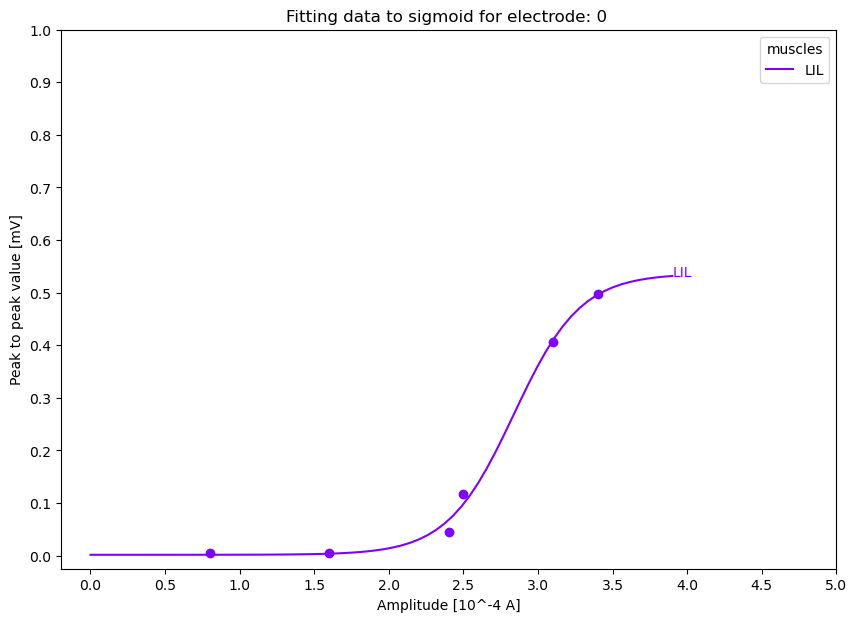

In [ ]:
if save_plot:
    plot_sigmoid_max_value_given(structure_class="muscles" ,data=peak2peak_data_to_tensor)


In [ ]:
muscles_popt_sigmoid=get_popt_per_combination(data =peak2peak_data_to_tensor, elec_i=0, muscle_i=0)

 outputs popt for LIL and elec 0


try to have data and fit in the legend

/var/folders/4j/9km7ny0j44x89rh9lkzx_51m0000gn/T/ipykernel_61781/88489939.py:8: RuntimeWarning: overflow encountered in exp
  y = L / (1 + np.exp(-k*(x-x0))) + b


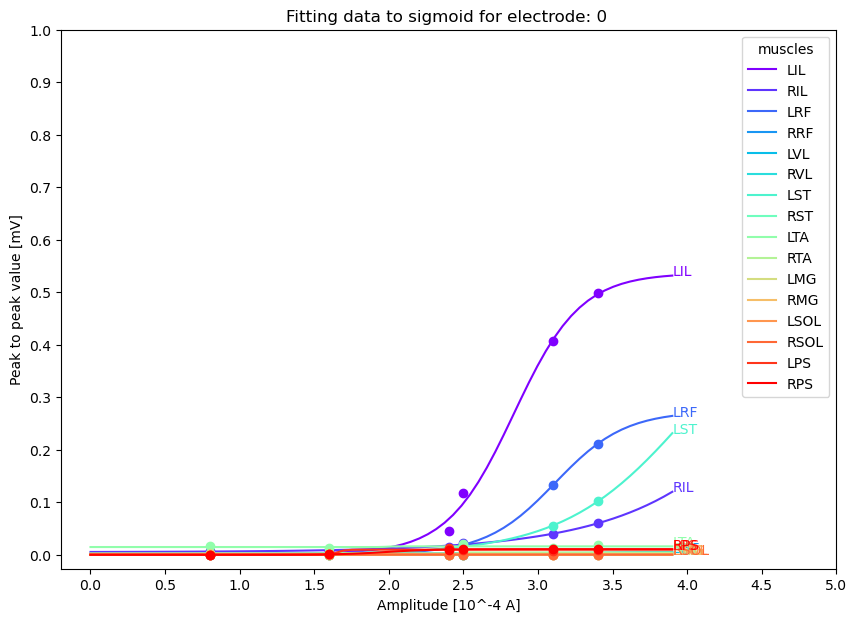

############################################################
Avoid RuntimeError and smoothen data for elec: 1
############################################################
Avoid RuntimeError and smoothen data for elec: 1


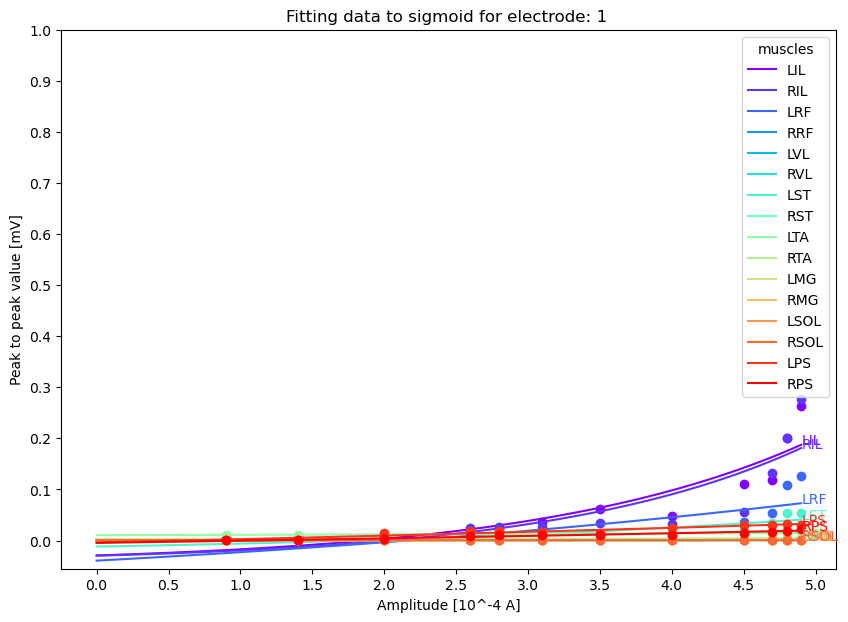

############################################################
Avoid RuntimeError and smoothen data for elec: 2


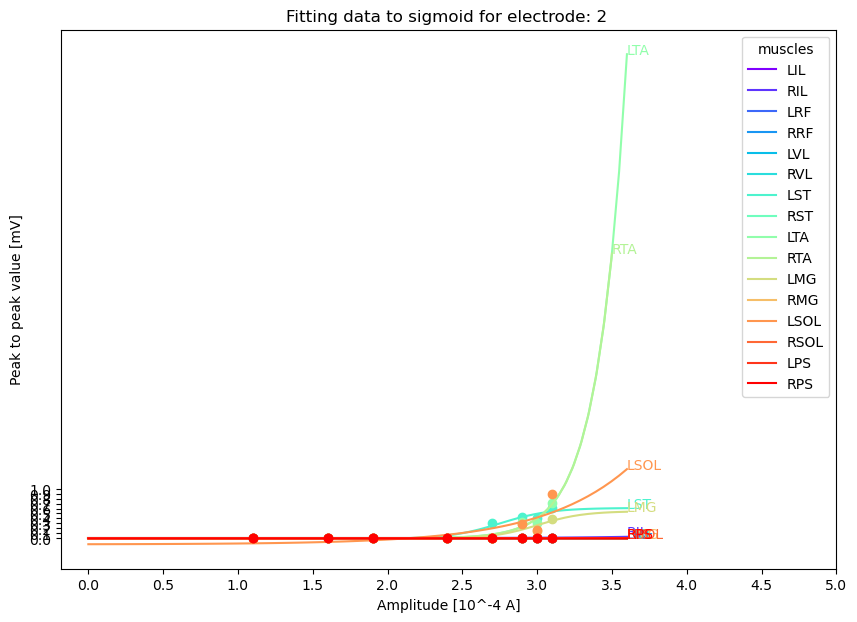

############################################################
Avoid RuntimeError and smoothen data for elec: 3
############################################################
Avoid RuntimeError and smoothen data for elec: 3


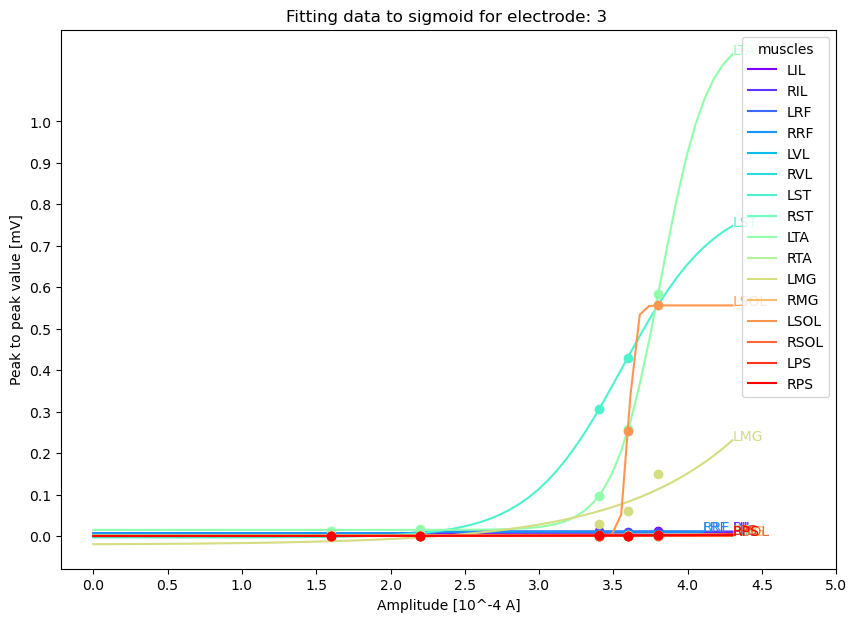

############################################################
Avoid RuntimeError and smoothen data for elec: 4


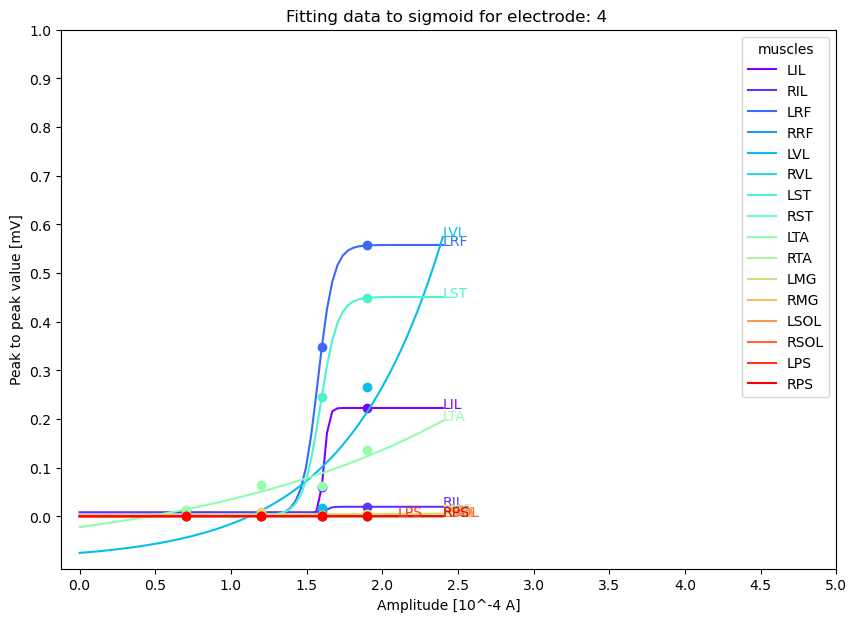

############################################################
Avoid RuntimeError and smoothen data for elec: 5
############################################################
Avoid RuntimeError and smoothen data for elec: 5


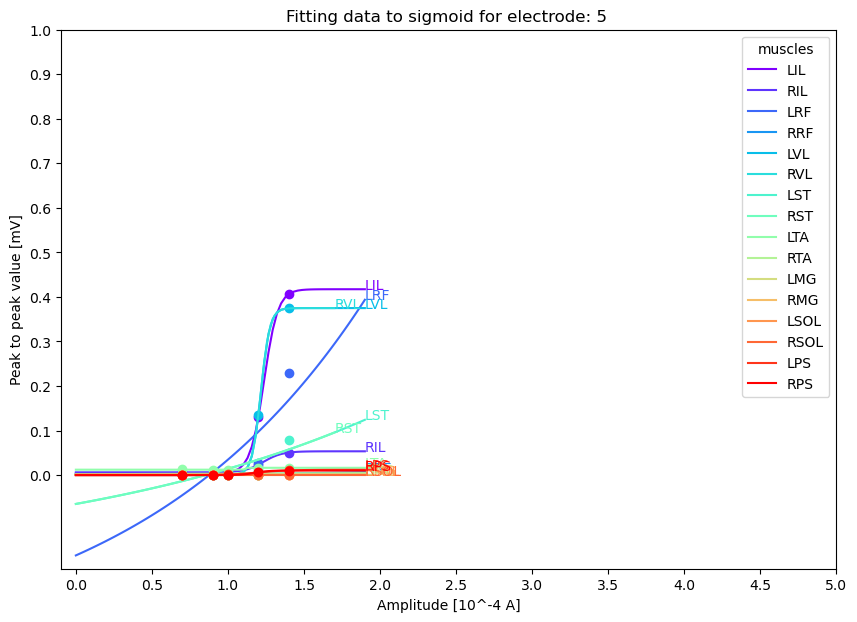

############################################################
Avoid RuntimeError and smoothen data for elec: 6


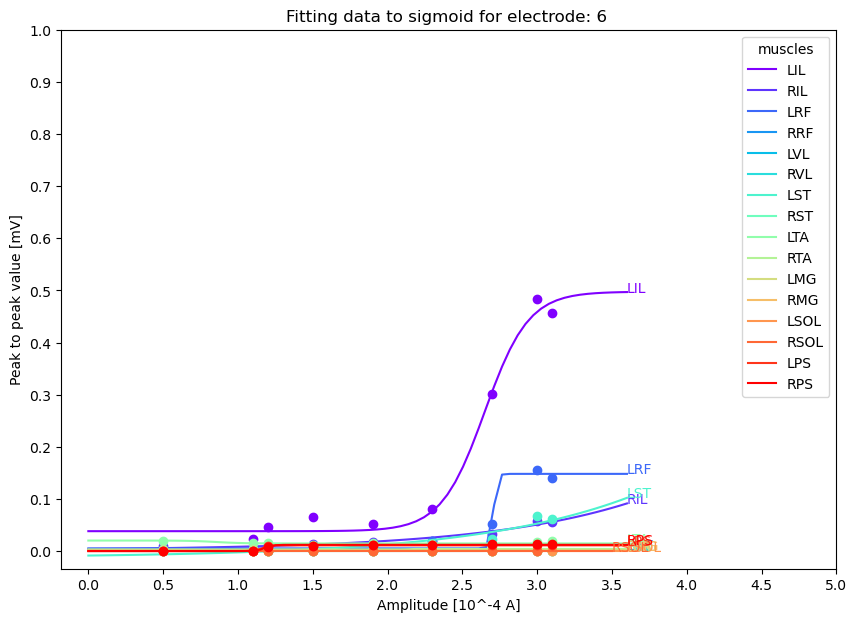

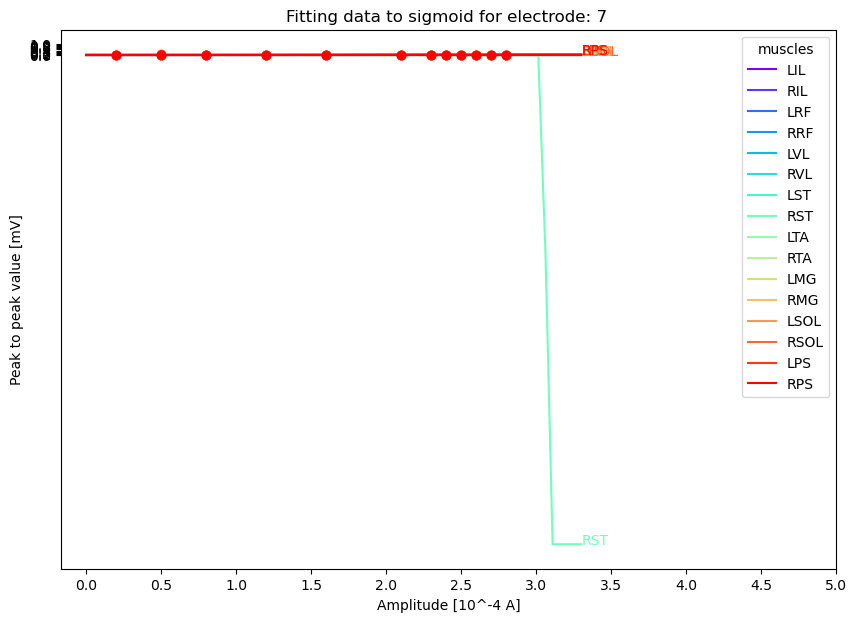

############################################################
Avoid RuntimeError and smoothen data for elec: 8


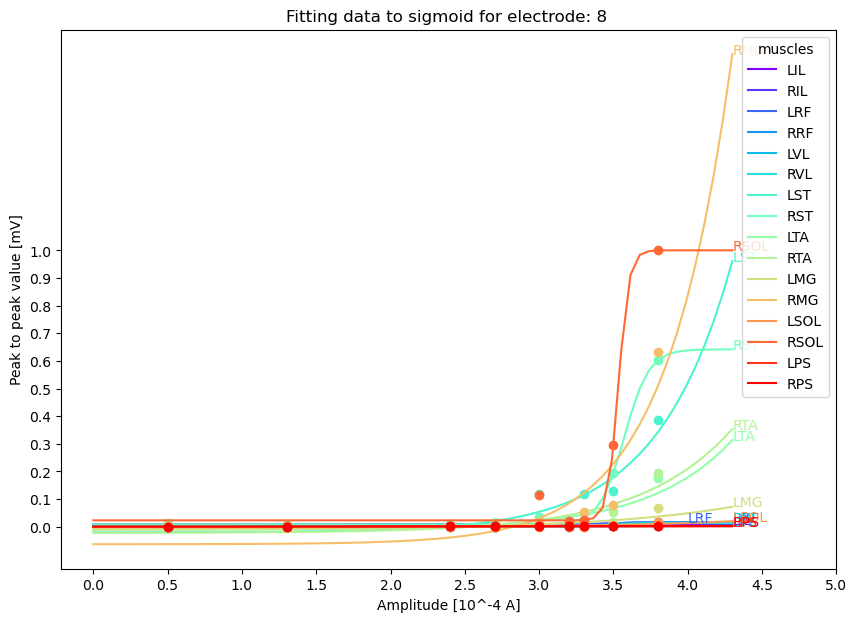

############################################################
Avoid RuntimeError and smoothen data for elec: 9
############################################################
Avoid RuntimeError and smoothen data for elec: 9


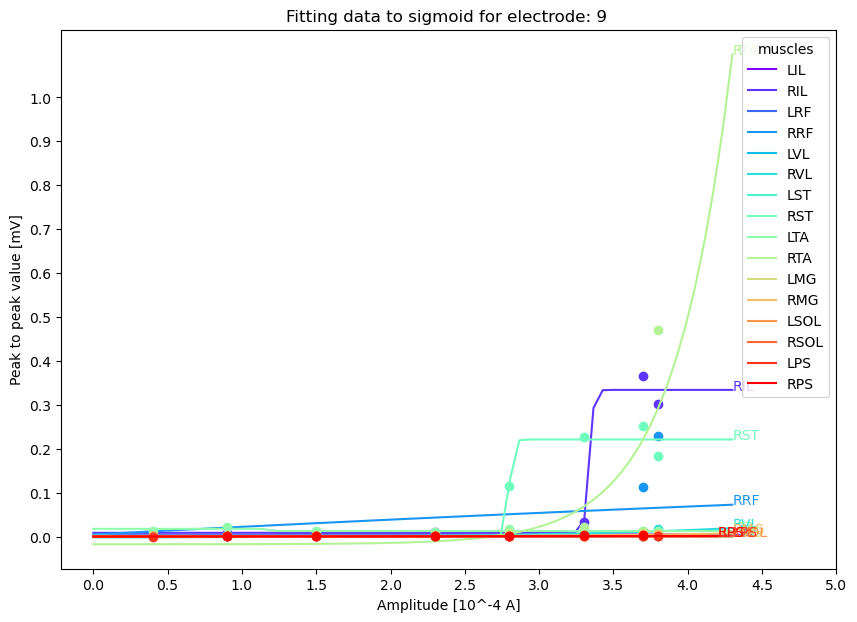

############################################################
Avoid RuntimeError and smoothen data for elec: 10
############################################################
Avoid RuntimeError and smoothen data for elec: 10


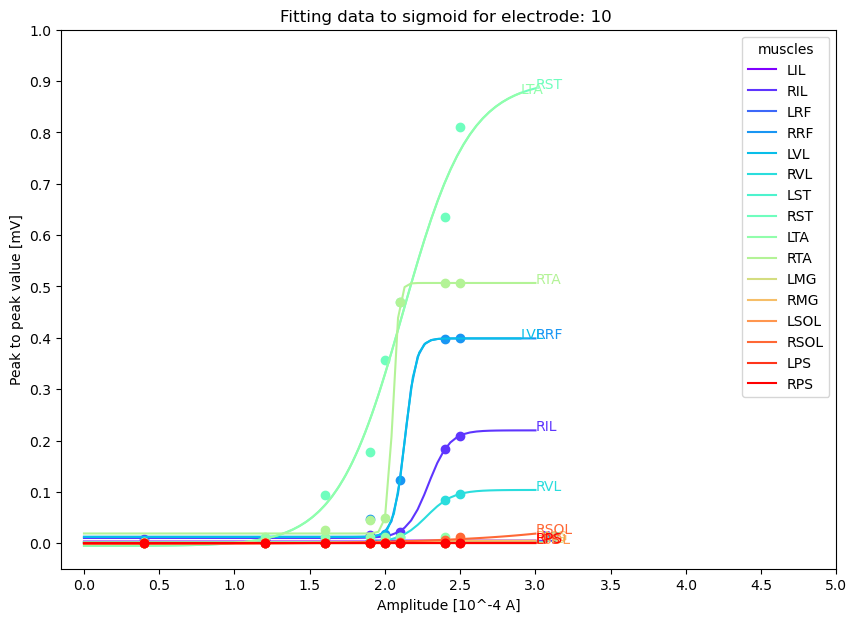

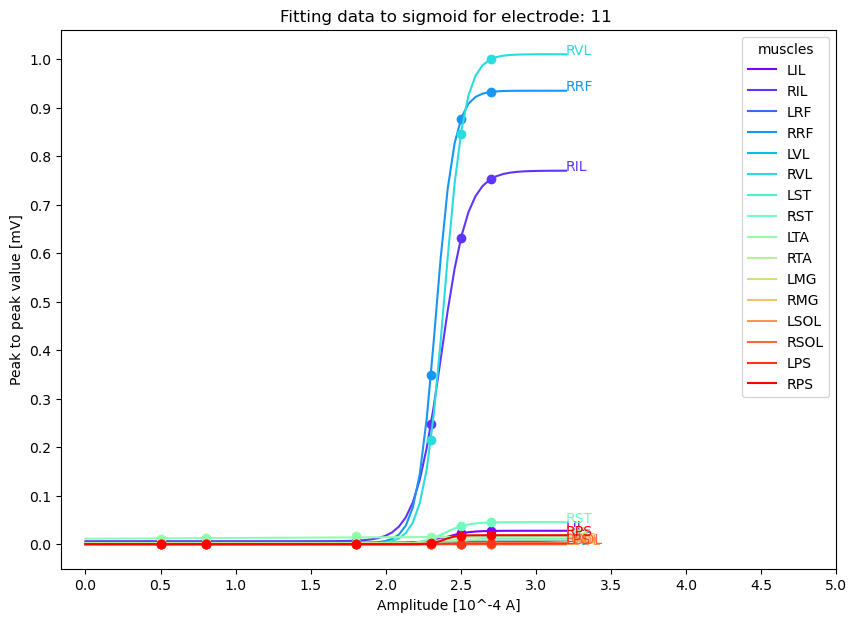

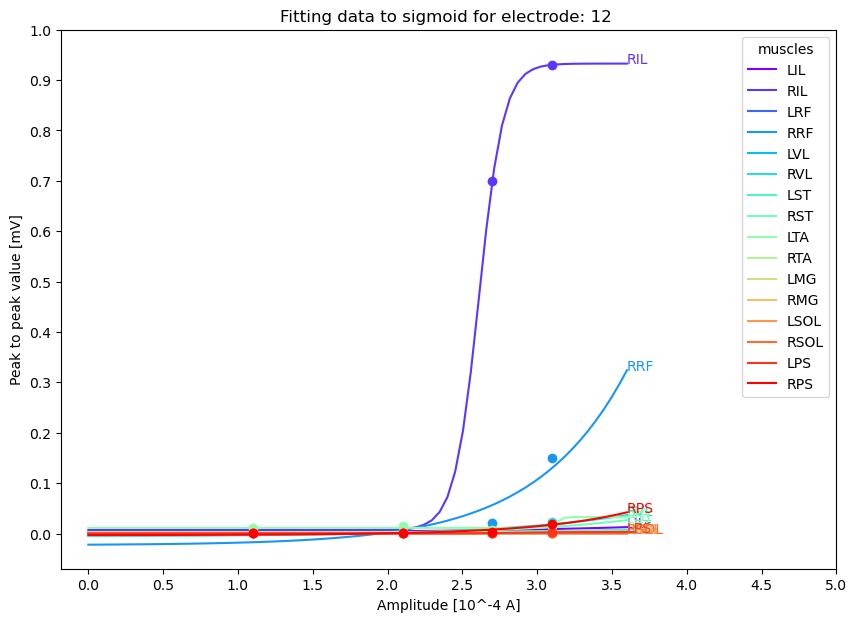

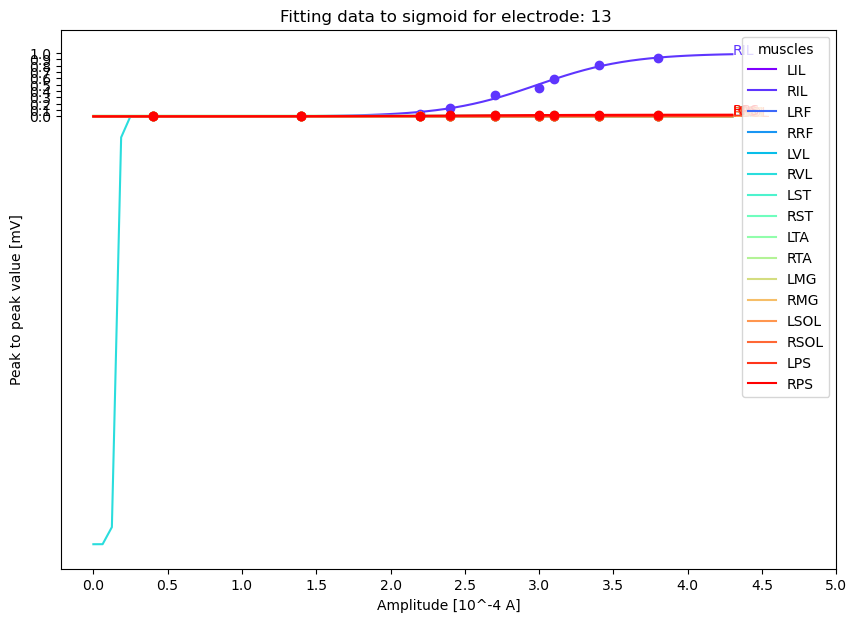

############################################################
Avoid RuntimeError and smoothen data for elec: 14


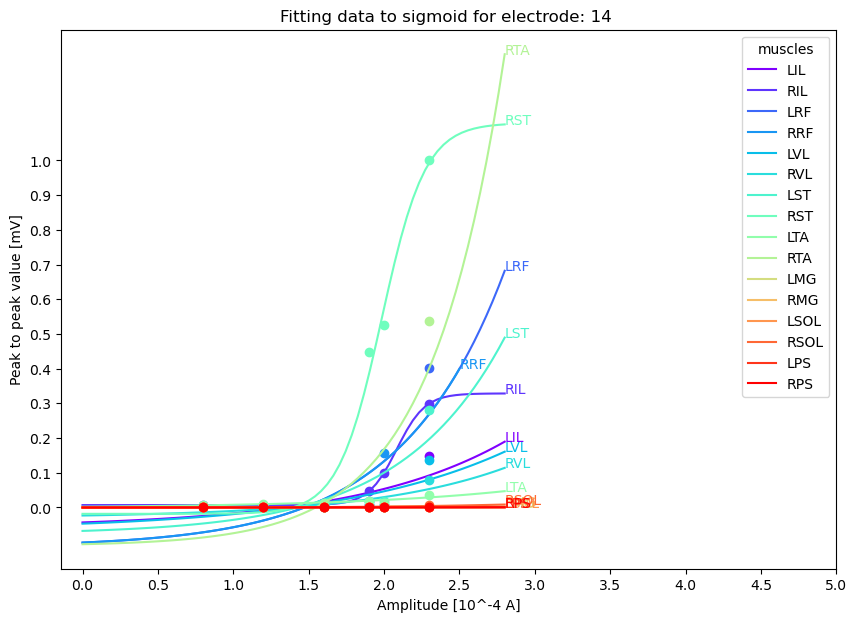

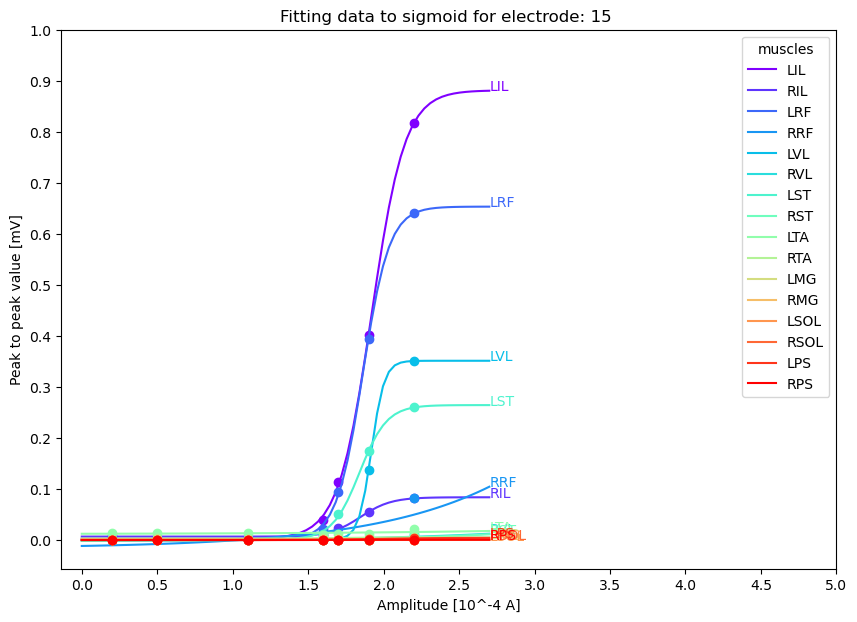

In [ ]:
## SErgio version all muscles , MAIN,for all elecs, working:D, amps multiplied by 10, seems to interpret the values better
from matplotlib import pylab
from pylab import *


from scipy.optimize import curve_fit
def sigmoid(x, L ,x0, k, b):
    y = L / (1 + np.exp(-k*(x-x0))) + b
    return (y)

# L is the limes 
# b adds bias, set to zero?
# k is responsible for scaling the input, how steep the curve, has to be >0
# x0, x value in the middle of the Sigmoid

# def fit_sigmoid_max_value_given(data=peak_peak_values, unique_amplitudes=unique_amplitudes, mt_muscles=mt_muscles,mt_electrodes=mt_electrodes):
# pcov is the error of a parameter in the model, Does the changing of the parameter slightly give a better fit? 
    #if pcov is very big, (=bad) , changing of the parameter doesnt have big of a influence, this we dont really know what is the (optimal) parameter 
# popt is the optimal parameters for the function

colors = cm.rainbow(np.linspace(0, 1, len(mt_muscles)))
label=mt_muscles["muscle_name"]
elec_i=2
save_fig=1

for elec_i in mt_electrodes["elec_name"]:
    
    # #exclude the muscles with max activation <0.05
    # muscle_over_0_05 =[]
    # for muscle_i in range (0, len(mt_muscles)):
    #     if np.nanmax(np.array(peak2peak_data_to_tensor[elec_i,muscle_i, :,0,0]))>0.05:
    #         muscle_over_0_05.append(muscle_i)

    # creating subplot
    fig, ax = plt.subplots(figsize=(10,7))
    for muscle_i in range (0, len(mt_muscles)):
    # for muscle_i in (muscle_over_0_05):
    

        ## Get rid of nan values
        peak_peak_values=np.array(peak2peak_data_to_tensor[elec_i,muscle_i, :,0,0]) # turn tensor into array
        mask = ~np.isnan(peak_peak_values) # search for posistions of nan values
        ydata=peak_peak_values[mask] # set y without nan values
        
        #multiply amplitdes by 10 , seems like it can interpret the values better
        xdata = np.array(unique_amplitudes["amplitudes"][mask])# set x for y
        xdata = xdata*10

        ##just to try add a zero to beginning of x data and y data for better fit?
        # xdata=np.append(0,xdata)
        # ydata=np.append(0, ydata)

       

        ## Initial guess for the parameters ##
        # The maximum asymptotic intensity. 
        L= max(ydata)
        #midpoint # The time point at which the sigmoidal curve reaches half of its maximum intensity.
        x0= np.median(xdata)
        #calculate the slope:  
        k=0.5
        # b, adds bias, take the lowest value of y data
        b=min(ydata)

        ## Get optimal parameters for sigmoid curve
        p0 =[L ,x0, k, b]



        ## to avoid RuntimeError: Optimal parameters not found: The maximum number of function evaluations is exceeded.
        ##smoothen data if needed
        try:
            popt, pcov = curve_fit(sigmoid, xdata, ydata,p0, method='dogbox',
            # bounds=(0,L)
            maxfev=10000
            )
            # print(f"opt:{popt}")
            # print(f"pcov:{pcov}")
        except:
            print("############################################################")
            print(f"Avoid RuntimeError and smoothen data for elec: {elec_i}")
            ## smoothen the data by convoluting it with a rectangle 
            # seems to look smoother, but is this feasible with so few data points?
            filt= np.ones(3)/3 # setting window to three points
            ydata_smooth= np.convolve(ydata, filt, mode="valid")
            ydata=ydata_smooth
            xdata=xdata[1:-1] # change borders, since we need space for the window
            

        ## define x and y for sigmoidal curve
        #interpolation should start before data and end a little after ( to see asymptote)
        if max(xdata)>44:
            last_x_value=49
        else:
            last_x_value=max(xdata)+5

        x=np.linspace(0, last_x_value, 70) #take a lot of steps for smoother curve, and doens't seem to have effect on pcov


        y = sigmoid(x, *popt)

        ax.plot(xdata, ydata, 'o', c=colors[muscle_i])
        ax.plot(x,y,  label=mt_muscles['muscle_name'][muscle_i], c=colors[muscle_i])

        # Add text descripiton to the points for visibility
        ax.text(x[-1], y[-1], label[muscle_i],c=colors[muscle_i], size=10) 
        # ax.text(xdata[-1], ydata[-1], label[muscle_i],c=colors[muscle_i], size=10)      

        
        ## set ticks
        ax.set_xticks(ticks=np.arange(0, 55,5), labels=np.linspace(0, 5,11)) # since amplitudes are multiplied by 10, customise the xlable
        ax.set_yticks(ticks=np.linspace(0, 1.,11))

        ax.set_xlabel("Amplitude [10^-4 A]")
        ax.set_ylabel("Peak to peak value [mV]")
        plt.legend(title="muscles")
        plt.title(f"Fitting data to sigmoid for electrode: {elec_i} ")
        
        save_fig=save_plot
        ## save plots ##
        if save_fig:
            data_file = "elec"+"_"+str(elec_i)+"_"+"sigmoid_fit_all_muscles"+'.png'
            folder_name="sigmoidal_fit/muscles/all"
            save_figure(folder_name, data_file)


    plt.show()


#### fit with normal amps

find literature, why I can multiply by 10

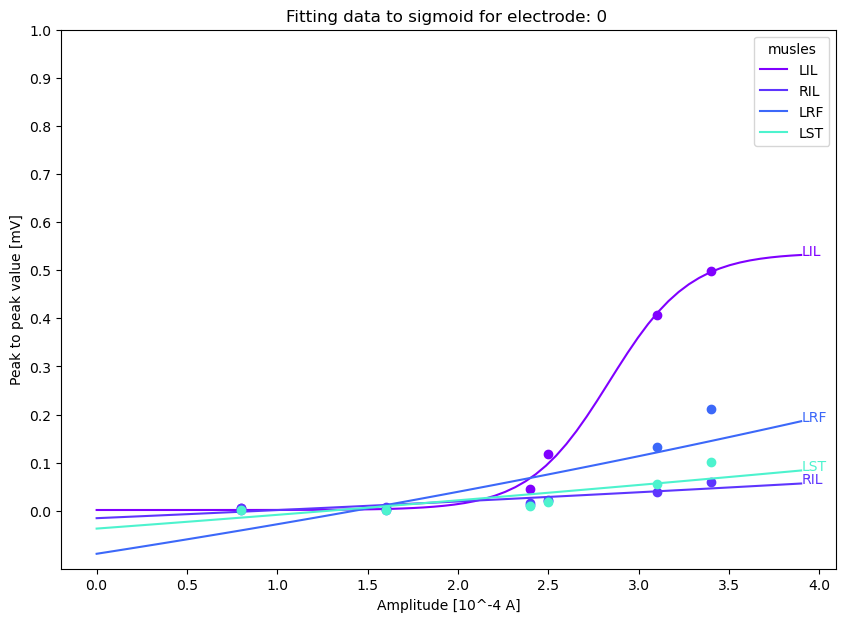

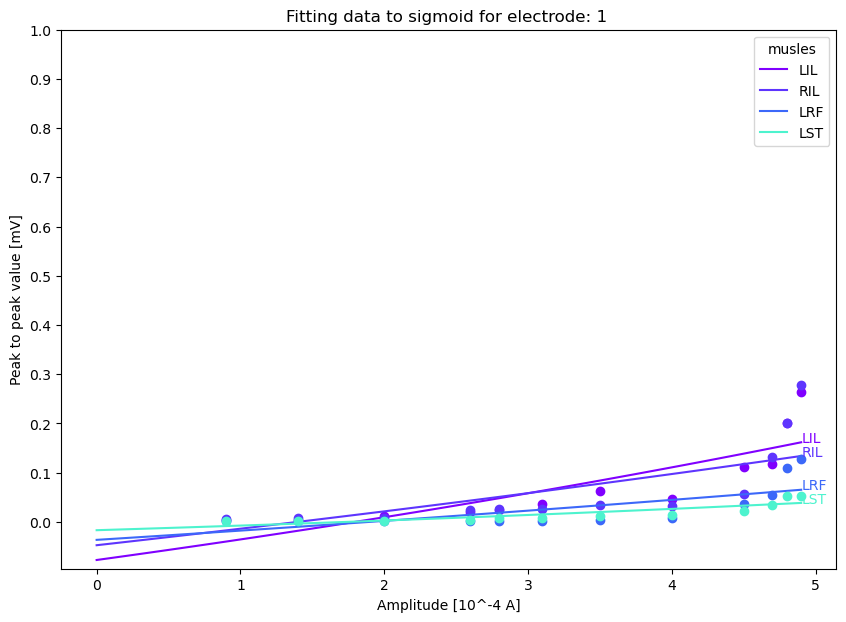

############################################################
OK, so it went wrong.


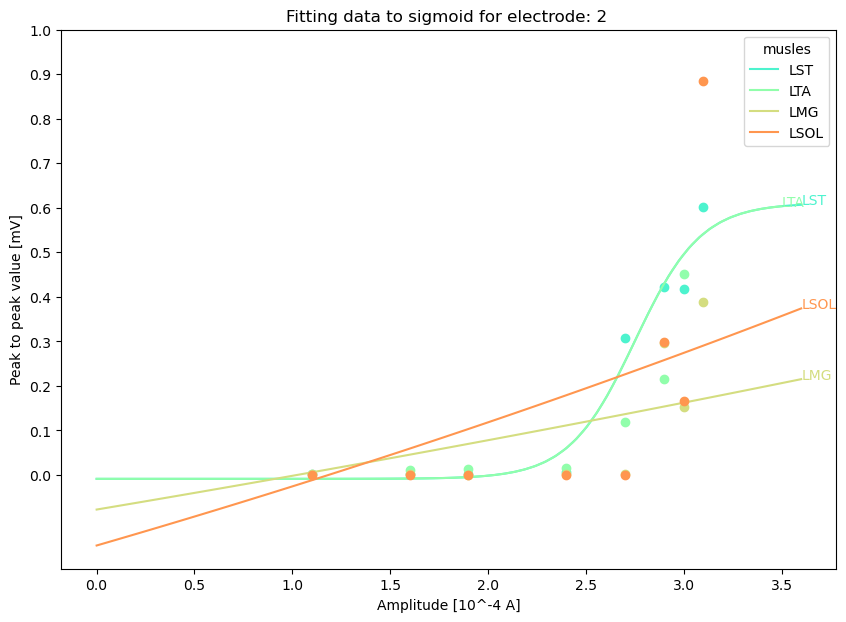

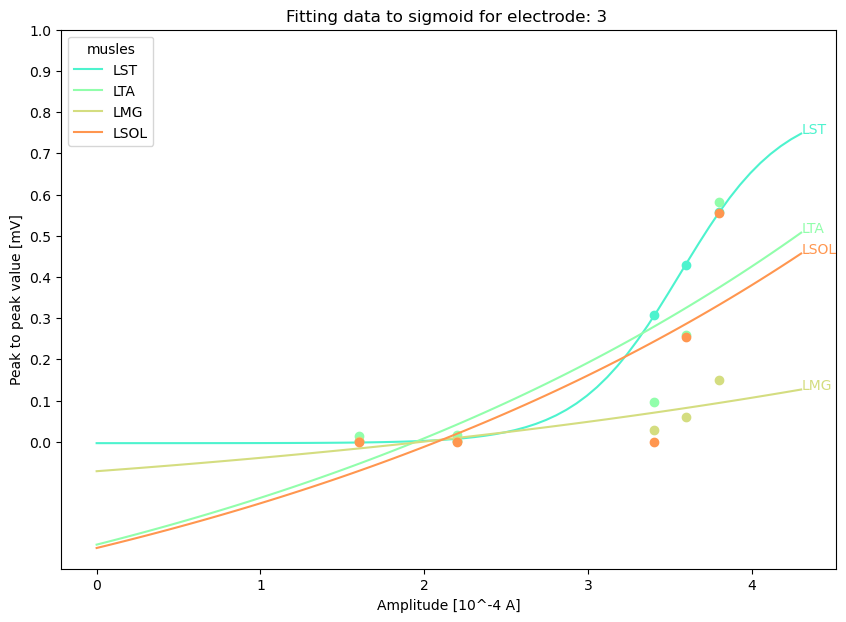

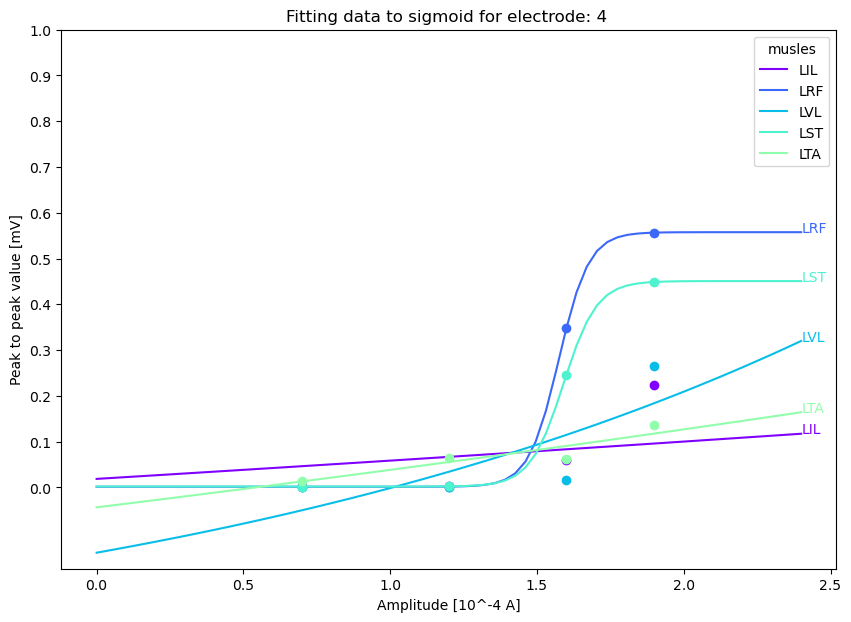

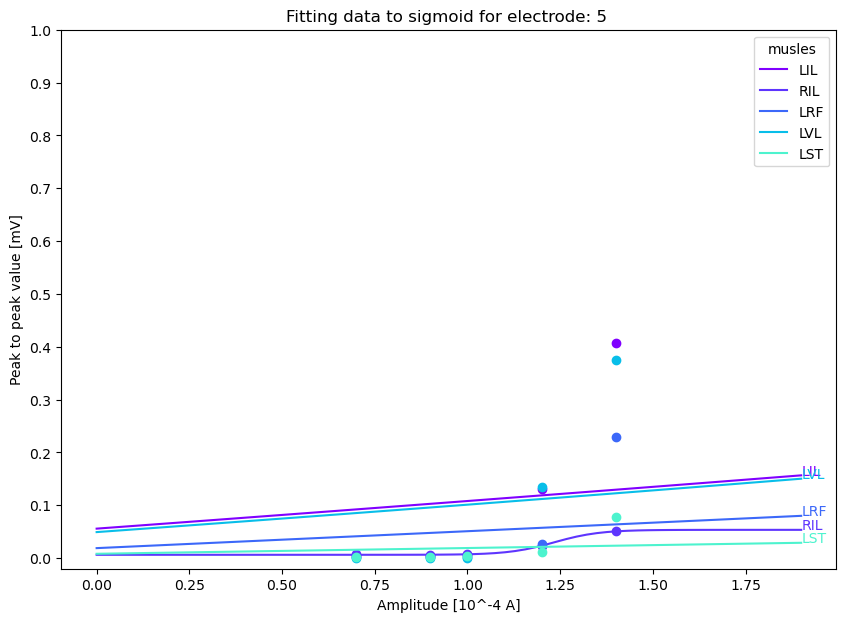

############################################################
OK, so it went wrong.
############################################################
OK, so it went wrong.


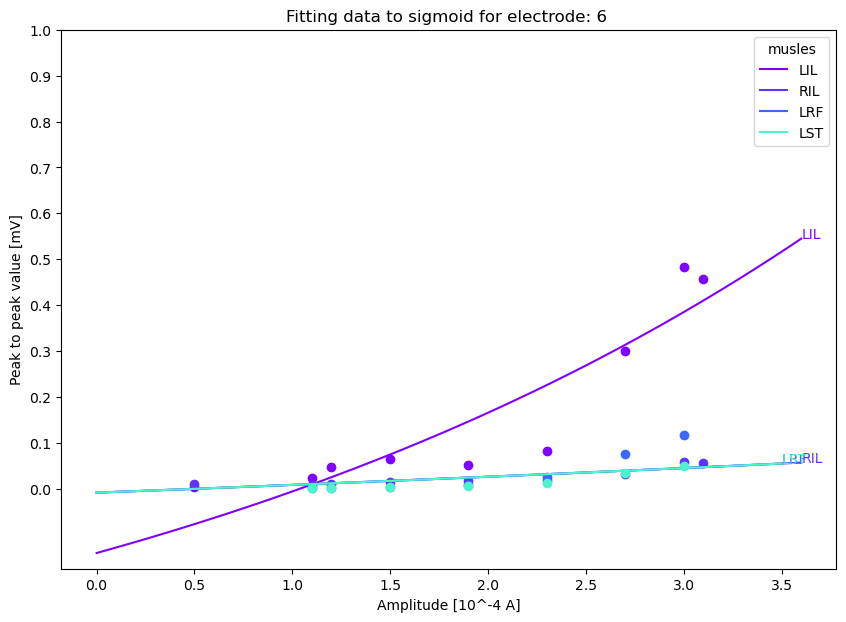

############################################################
OK, so it went wrong.


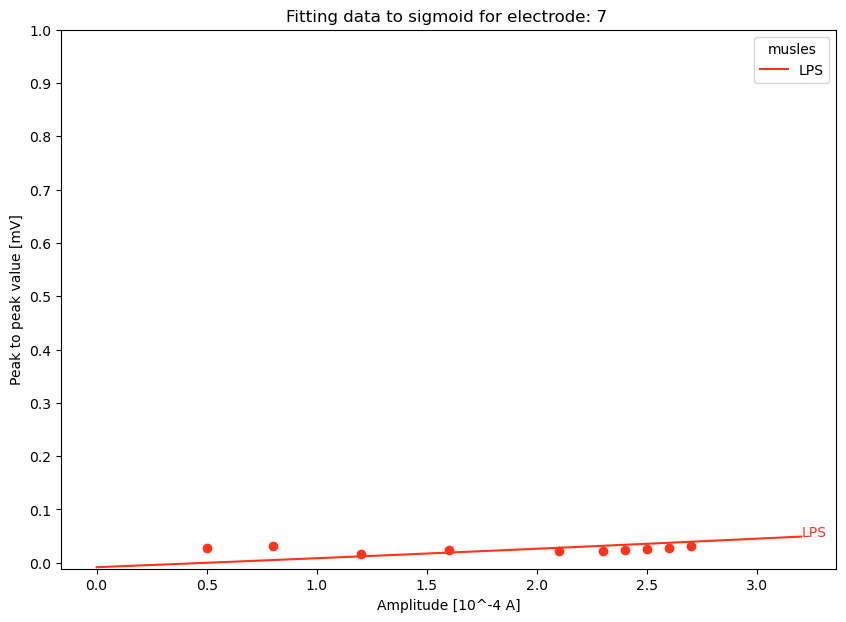

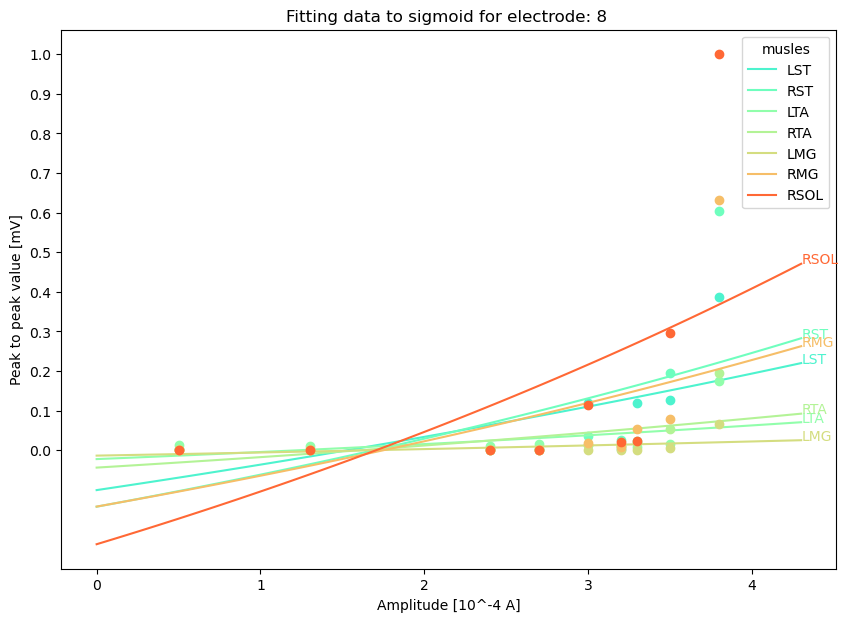

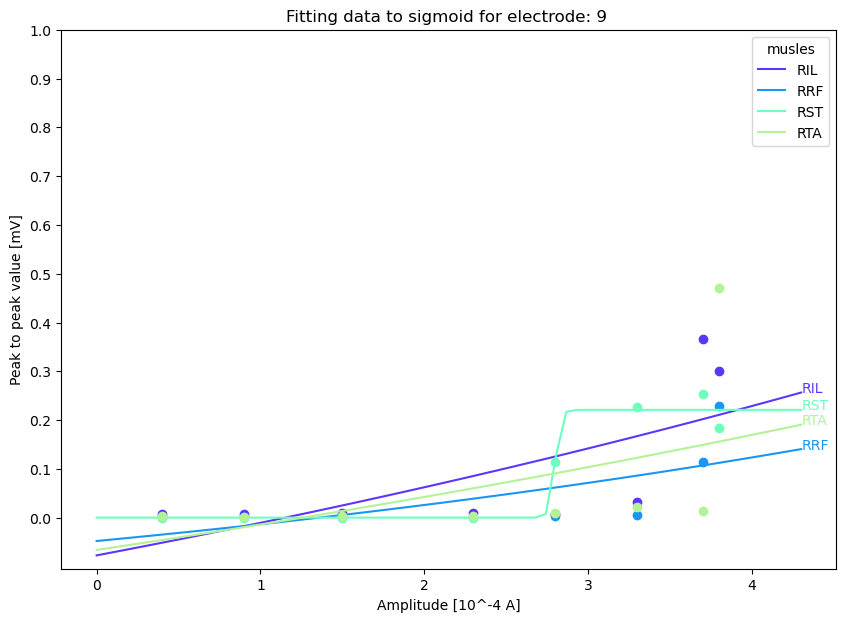

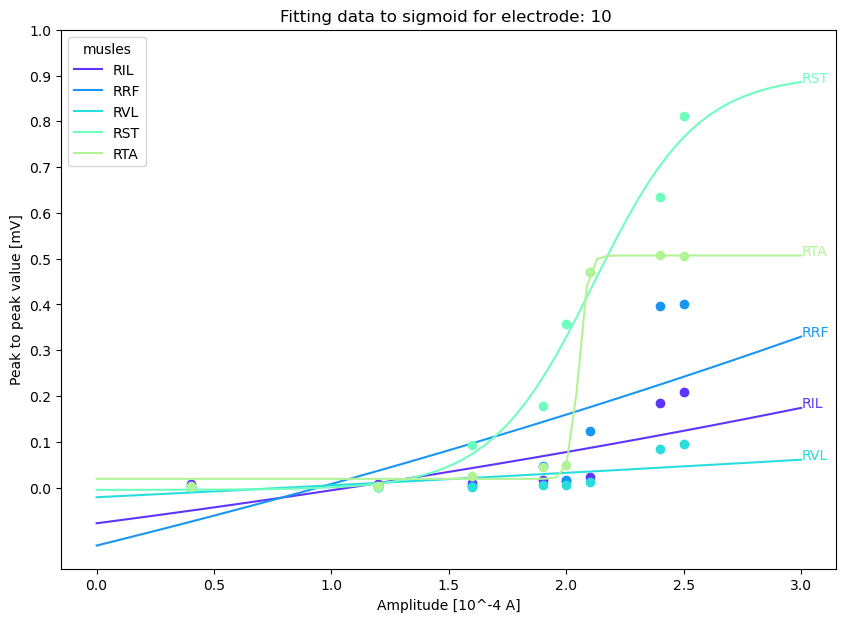

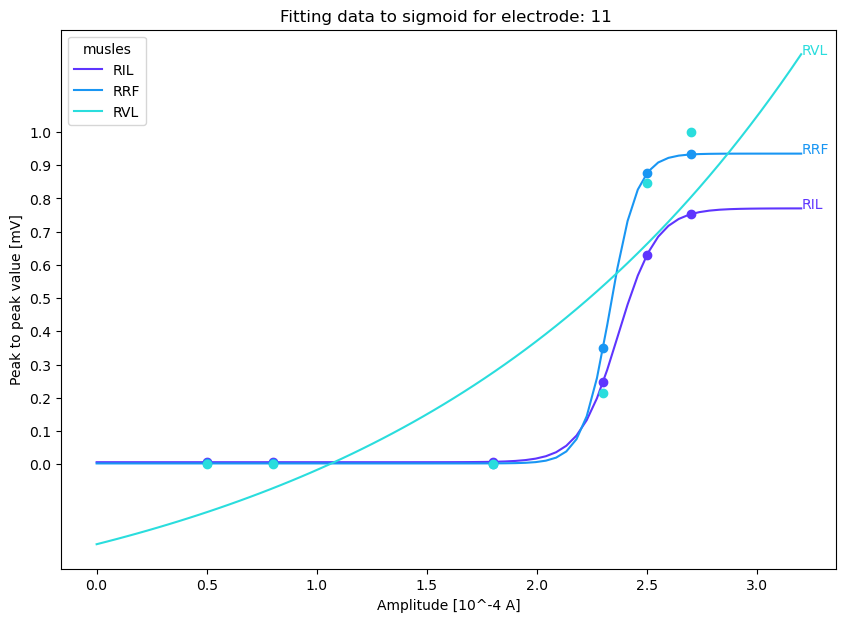

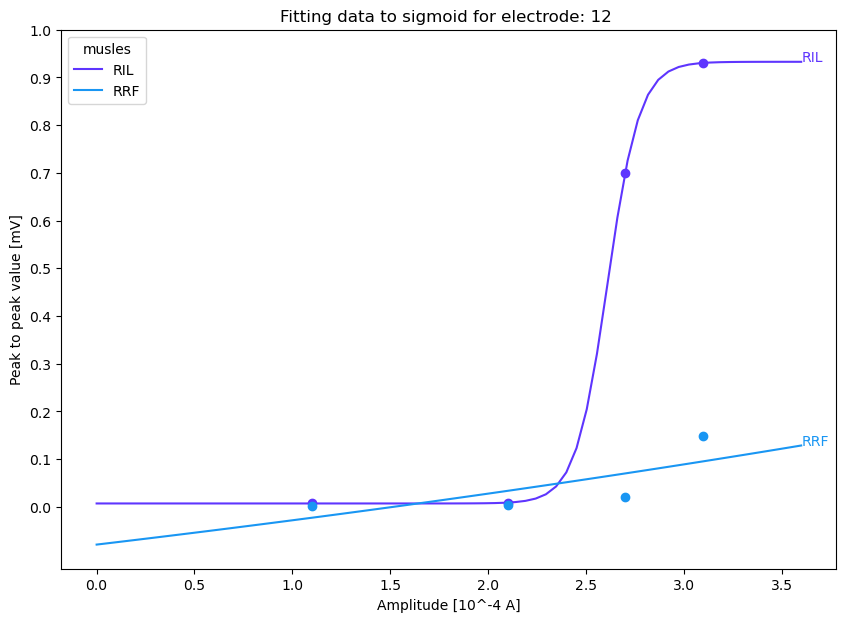

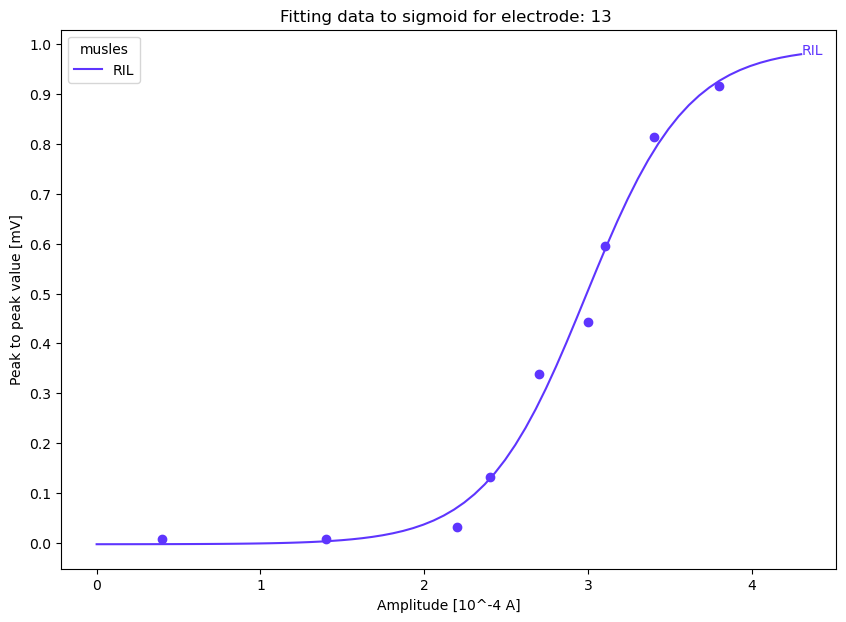

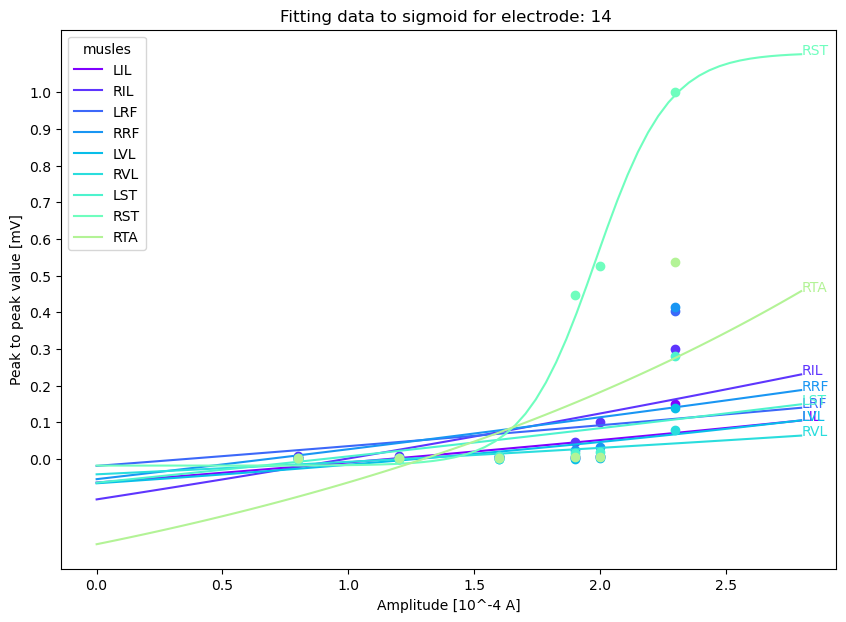

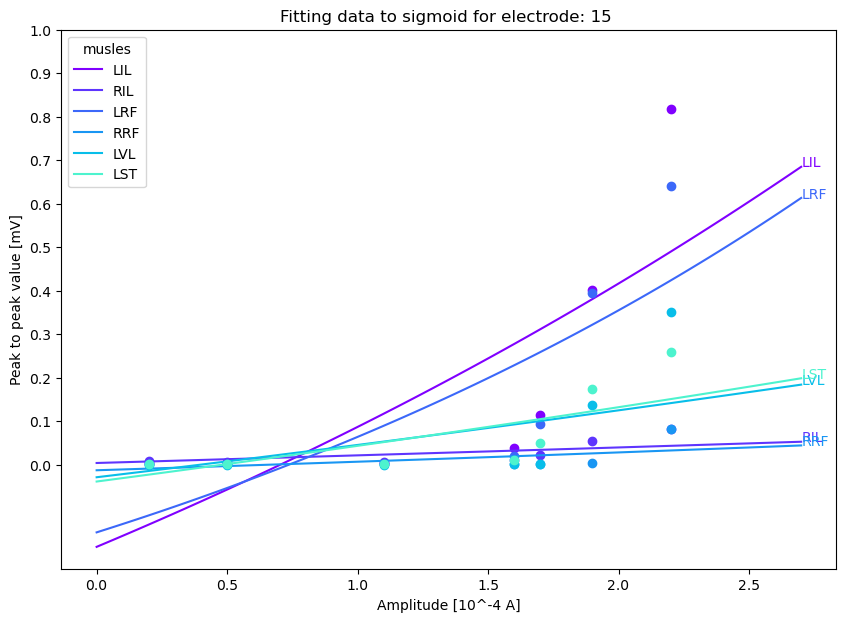

In [ ]:
## SErgio version all muscles , for all elecs, working:D, amps normal
from matplotlib import pylab
from pylab import *


from scipy.optimize import curve_fit
def sigmoid(x, L ,x0, k, b):
    y = L / (1 + np.exp(-k*(x-x0))) + b
    return (y)

# L is the limes 
# b adds bias, set to zero?
# k is responsible for scaling the input, how steep the curve, has to be >0
# x0, x value in the middle of the Sigmoid

# def fit_sigmoid_max_value_given(data=peak_peak_values, unique_amplitudes=unique_amplitudes, mt_muscles=mt_muscles,mt_electrodes=mt_electrodes):
# pcov is the error of a parameter in the model, Does the changing of the parameter slightly give a better fit? 
    #if pcov is very big, (=bad) , changing of the parameter doesnt have big of a influence, this we dont really know what is the (optimal) parameter 
# popt is the optimal parameters for the function

colors = cm.rainbow(np.linspace(0, 1, len(mt_muscles)))
label=mt_muscles["muscle_name"]
elec_i=2
save_fig=0

for elec_i in mt_electrodes["elec_name"]:
    
    #exclude the muscles with max activation <0.05
    muscle_over_0_05 =[]
    for muscle_i in range (0, len(mt_muscles)):
        if np.nanmax(np.array(peak2peak_data_to_tensor[elec_i,muscle_i, :,0,0]))>0.05:
            muscle_over_0_05.append(muscle_i)

    # creating subplot
    fig, ax = plt.subplots(figsize=(10,7))
    # for muscle_i in range (0, len(mt_muscles)):
    for muscle_i in (muscle_over_0_05):
    

        ## Get rid of nan values
        peak_peak_values=np.array(peak2peak_data_to_tensor[elec_i,muscle_i, :,0,0]) # turn tensor into array
        mask = ~np.isnan(peak_peak_values) # search for posistions of nan values
        ydata=peak_peak_values[mask] # set y without nan values
        #multiply amplitdes by 10 ,to make sure they are
        xdata = np.array(unique_amplitudes["amplitudes"][mask])# set x for y
        # xdata = xdata*10

        ##just to try add a zero to beginning of x data and y data for better fit?
        # xdata=np.append(0,xdata)
        # ydata=np.append(0, ydata)

       

        ## Initial guess for the parameters ##
        # The maximum asymptotic intensity. 
        L= max(ydata)
        #midpoint # The time point at which the sigmoidal curve reaches half of its maximum intensity.
        x0= np.median(xdata)
        #calculate the slope:  
        k=0.5
        # b, adds bias, take the lowest value of y data
        b=min(ydata)

        ## Get optimal parameters for sigmoid curve
        p0 =[L ,x0, k, b]





        try:
            popt, pcov = curve_fit(sigmoid, xdata, ydata,p0, method='dogbox',
            # bounds=(0,L)
            maxfev=10000
            )
            # print(f"opt:{popt}")
            # print(f"pcov:{pcov}")
        except:
            print("############################################################")
            print("OK, so it went wrong.")
            ## smoothen the data by convoluting it with a rectangle 
            # seems to look smoother, but is this feasible with so few data points?
            filt= np.ones(3)/3 # setting window to three points
            ydata_smooth= np.convolve(ydata, filt, mode="valid")
            ydata=ydata_smooth
            xdata=xdata[1:-1] # change borders, since we need space for the window
            

        ## define x and y for sigmoidal curve
        # x=np.linspace(0, 50, 60) # interpolation should start before data and end a little after ( to see asymptote), and in steps of 0.1 
        # x=np.linspace(min(xdata), max(xdata)+5, len(xdata)+1)
        # x=np.linspace(min(xdata), max(xdata)+5, 50) #take a lot of steps for smoother curve, and doens't seem to have effect on pcov
        
        # if max(xdata)>44:
        #     last_x_value=49
        # else:
        #     last_x_value=max(xdata)+5

        # x=np.linspace(0, last_x_value, 70) #take a lot of steps for smoother curve, and doens't seem to have effect on pcov


        if max(xdata)>4.4:
            last_x_value=4.9
        else:
            last_x_value=max(xdata)+0.5
            
        x=np.linspace(0, last_x_value, 70)

        y = sigmoid(x, *popt)

        ax.plot(xdata, ydata, 'o', c=colors[muscle_i])
        ax.plot(x,y,  label=mt_muscles['muscle_name'][muscle_i], c=colors[muscle_i])

        # Add text descripiton to the points for visibility
        ax.text(x[-1], y[-1], label[muscle_i],c=colors[muscle_i], size=10) 
        # ax.text(xdata[-1], ydata[-1], label[muscle_i],c=colors[muscle_i], size=10)      

        plt.ylabel("Peak to peak value [mV]")


        # set ticks
        # ax.set_xticks(ticks=xdata, labels=np.divide(xdata, 10))
        # ax.set_xticks(ticks=np.arange(0, 55,5), labels=np.linspace(0, 5,11)) # since amplitudes are multiplied by then, customise the xlable
        ax.set_yticks(ticks=np.linspace(0, 1.,11))

        ax.set_xlabel("Amplitude [10^-4 A]")
        plt.legend(title="musles")
        plt.title(f"Fitting data to sigmoid for electrode: {elec_i} ")
        
        ## save plots ##
        if save_fig:
            data_file = "elec"+"_"+str(elec_i)+"_"+"sigmoid_fit"+'.png'
            folder_name="sigmoidal_fit/muscles"
            save_figure(folder_name, data_file)


    plt.show()


#### helps to analyze results

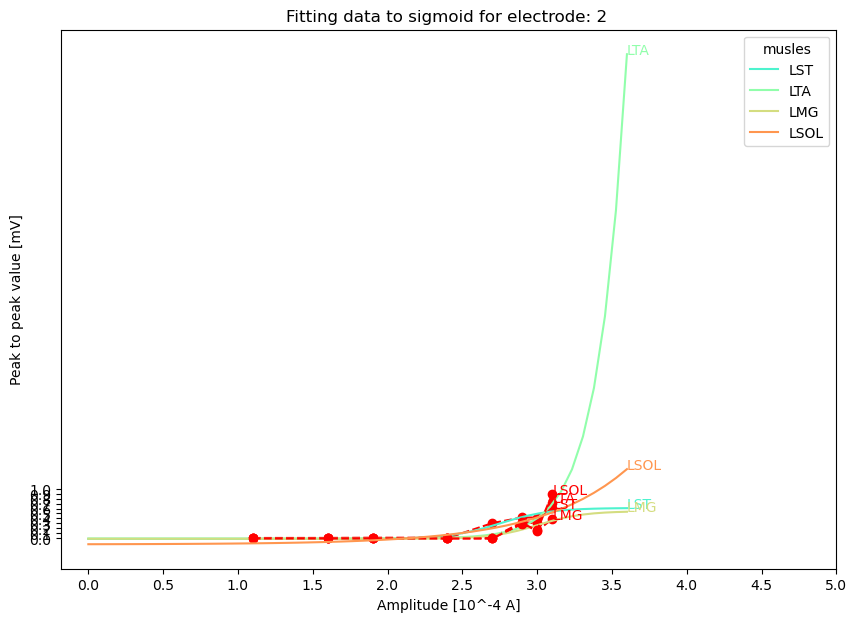

In [ ]:
## SErgio version all muscles,main,  add changes here
from matplotlib import pylab
from pylab import *


from scipy.optimize import curve_fit
def sigmoid(x, L ,x0, k, b):
    y = L / (1 + np.exp(-k*(x-x0))) + b
    return (y)

# L is the limes 
# b adds bias, set to zero?
# k is responsible for scaling the input, how steep the curve, has to be >0
# x0, x value in the middle of the Sigmoid

# def fit_sigmoid_max_value_given(data=peak_peak_values, unique_amplitudes=unique_amplitudes, mt_muscles=mt_muscles,mt_electrodes=mt_electrodes):
# pcov is the error of a parameter in the model, Does the changing of the parameter slightly give a better fit? 
    #if pcov is very big, (=bad) , changing of the parameter doesnt have big of a influence, this we dont really know what is the (optimal) parameter 
# popt is the optimal parameters for the function

colors = cm.rainbow(np.linspace(0, 1, len(mt_muscles)))
label=mt_muscles["muscle_name"]
elec_i=2

#exclude the muscles with max activation <0.05
muscle_over_0_05 =[]
for muscle_i in range (0, len(mt_muscles)):
    if np.nanmax(np.array(peak2peak_data_to_tensor[elec_i,muscle_i, :,0,0]))>0.05:
        muscle_over_0_05.append(muscle_i)

# creating subplot
fig, ax = plt.subplots(figsize=(10,7))
# for muscle_i in range (0, len(mt_muscles)):
for muscle_i in (muscle_over_0_05):
   

    ## Get rid of nan values
    peak_peak_values=np.array(peak2peak_data_to_tensor[elec_i,muscle_i, :,0,0]) # turn tensor into array
    mask = ~np.isnan(peak_peak_values) # search for posistions of nan values
    ydata=peak_peak_values[mask] # set y without nan values
    #multiply amplitdes by 10 ,to make sure they are
    xdata = np.array(unique_amplitudes["amplitudes"][mask]) *10 # set x for y

    ## add a zero to beginning of x data and y data for better fit?
    ## actually outputs a worse fit
    # xdata=np.append(0,xdata)
    # ydata=np.append(0, ydata)

    # ## smoothen the data by convoluting it with a rectangle 
    # # seems to look smoother, but is this feasible with so few data points?
    # filt= np.ones(3)/3 # setting window to three points
    # ydata_smooth= np.convolve(ydata, filt, mode="valid")
    # ydata=ydata_smooth
    # xdata=xdata[1:-1] # change borders, since we need space for the window
        

    ## Initial guess for the parameters ##
    # The maximum asymptotic intensity. 
    L= max(ydata)
    #midpoint # The time point at which the sigmoidal curve reaches half of its maximum intensity.
    x0= np.median(xdata)
    #calculate the slope:  
    k=0.5
    # b, adds bias, take the lowest value of y data
    b=min(ydata)

    ## Get optimal parameters for sigmoid curve
    p0 =[L ,x0, k, b]
    popt, pcov = curve_fit(sigmoid, xdata, ydata,p0, method='dogbox',
    # bounds=(0,L)
     maxfev=10000
    )
    # print(f"opt:{popt}")
    # print(f"pcov:{pcov}")

    ## define x and y for sigmoidal curve
    # x=np.linspace(0, 50, 60) # interpolation should start before data and end a little after ( to see asymptote), and in steps of 0.1 
    # x=np.linspace(min(xdata), max(xdata)+5, len(xdata)+1)
    # x=np.linspace(min(xdata), max(xdata)+5, 50) #take a lot of steps for smoother curve, and doens't seem to have effect on pcov
    if max(xdata)>44:
        last_x_value=49
    else:
        last_x_value=max(xdata)+5
    x=np.linspace(0, last_x_value, 50) #take a lot of steps for smoother curve, and doens't seem to have effect on pcov

    y = sigmoid(x, *popt)

    ax.plot(xdata, ydata, 'o--', color= "red")
    ax.plot(x,y,  label=mt_muscles['muscle_name'][muscle_i], c=colors[muscle_i])

    # Add text descripiton to the points for visibility
    ax.text(x[-1], y[-1], label[muscle_i],c=colors[muscle_i], size=10) 
    ax.text(xdata[-1], ydata[-1], label[muscle_i],c="red", size=10)      

    plt.ylabel("Peak to peak value [mV]")


    # set ticks
    # ax.set_xticks(ticks=xdata, labels=np.divide(xdata, 10))
    ax.set_xticks(ticks=np.arange(0, 55,5), labels=np.linspace(0, 5,11)) # since amplitudes are multiplied by then, customise the xlable
    ax.set_yticks(ticks=np.linspace(0, 1.,11))

    ax.set_xlabel("Amplitude [10^-4 A]")
    plt.legend(title="musles")
    plt.title(f"Fitting data to sigmoid for electrode: {elec_i} ")
    # fig, ax = plt.subplots(figsize=(10,7))




    # set ticks

    # ticks=np.arange(0, len(amplitudes))
    # labels=amplitudes
    # ax.set_xticks(ticks, labels=labels)




plt.show()


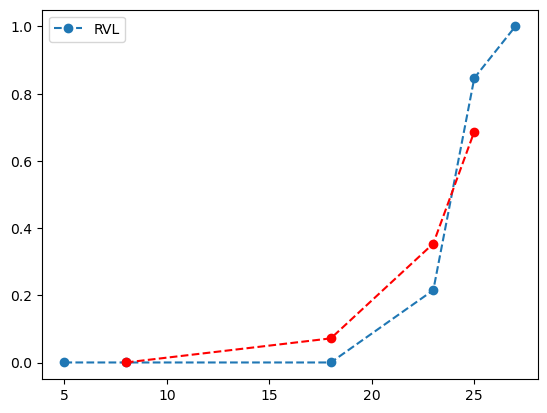

In [ ]:
elec_i=11
muscle_i=8


# for muscle_i in range(0,len(mt_muscles)):
for muscle_i in [5]:
    ## Get rid of nan values
    peak_peak_values=np.array(peak2peak_data_to_tensor[elec_i,muscle_i, :,0,0]) # turn tensor into array
    mask = ~np.isnan(peak_peak_values) # search for posistions of nan values
    ydata=peak_peak_values[mask] # set y without nan values
    #multiply amplitdes by 10 ,to make sure they are
    xdata = np.array(unique_amplitudes["amplitudes"][mask]) *10 # set x for y

    filt= np.ones(3)/3 # setting window to three points
    
    ydata_smooth= np.convolve(ydata, filt, mode="valid")
    plt.plot(xdata, ydata, "o--", label=mt_muscles["muscle_name"][muscle_i])
    plt.plot(xdata[1:-1], ydata_smooth, "o--", c="red")
    plt.legend()
    plt.show()

In [ ]:
elec_i=5
muscle_i=2

## Get rid of nan values
peak_peak_values=np.array(peak2peak_data_to_tensor[elec_i,muscle_i, :,0,0]) # turn tensor into array
mask = ~np.isnan(peak_peak_values) # search for posistions of nan values
ydata=peak_peak_values[mask] # set y without nan values
#multiply amplitdes by 10 ,to make sure they are
xdata = np.array(unique_amplitudes["amplitudes"][mask]) *10 # set x for y

#### Version assuming max value is at higher amplitude

In [ ]:
# Neala version  original


import numpy as np
import pylab
from scipy.optimize import curve_fit


data_structure= "max_P2P_div_amp"

def sigmoid(x, x0, k):
     y = 1 / (1 + np.exp(-k*(x-x0)))
     return y
# k>0

# Take slice of tensor and get rid of nan values
peak_peak_values=pd.DataFrame(peak2peak_data_to_tensor[muscle_i,elec_i,:,0,0]) #Convert tensor slice to df
peak_peak_values=peak_peak_values.dropna() #Get rid of nan values
peak_peak_values=np.array(peak_peak_values[0]) #Convert to np array
# Set values to plot for original data
xdata=np.arange(0, len(peak_peak_values)) 
ydata=peak_peak_values

# Set the given amplitudes as a x-label
amplitudes=pd.DataFrame(amplitude_filtereddata_to_tensor[muscle_i,elec_i,:])
amplitudes=amplitudes.dropna()
amplitudes=np.array(amplitudes[0])

# Find Optimal values for the parameters( popt) so that the sum of the squared residuals of f(xdata, *popt) - ydata is minimized.
popt, pcov = curve_fit(sigmoid, xdata, ydata)
print (popt)

# Set values to plot for interpolated data
x = np.linspace(-1, 15, 50) # How did I set this parameter ? 
y = sigmoid(x, *popt)

fig, ax = plt.subplots(figsize=(10,7))
plt.ylabel("Peak to peak value [mV]")
plt.xlabel("Amplitudes [mA]")
plt.title(f"Sigmoid fit asymptotic value after max data value,  elec: {elec_i}, muscle: {mt_muscles['muscle_name'][muscle_i]}")
ticks=np.arange(0, len(amplitudes))
labels=amplitudes
ax.set_xticks(ticks, labels=labels)

pylab.plot(xdata, ydata, 'o', label='data')
pylab.plot(x,y, label='fit')
pylab.ylim(0, 1.05)
pylab.legend(loc='best')

#Get original peak to peak, without dividing by amplitude, otherwise overfitting?
# ## Define Textbox
# axbox = fig.add_axes([0, 1.0, 1.0, 0.05]) #[left, bottom, width, height]
# text_box = TextBox(axbox,label=None, textalignment="center")
# text_box.set_val(f"Normalisation method: {data_structure}")  # Trigger `submit` with the initial string.

pylab.show()

RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 600.

[4.81608384 0.92039473]


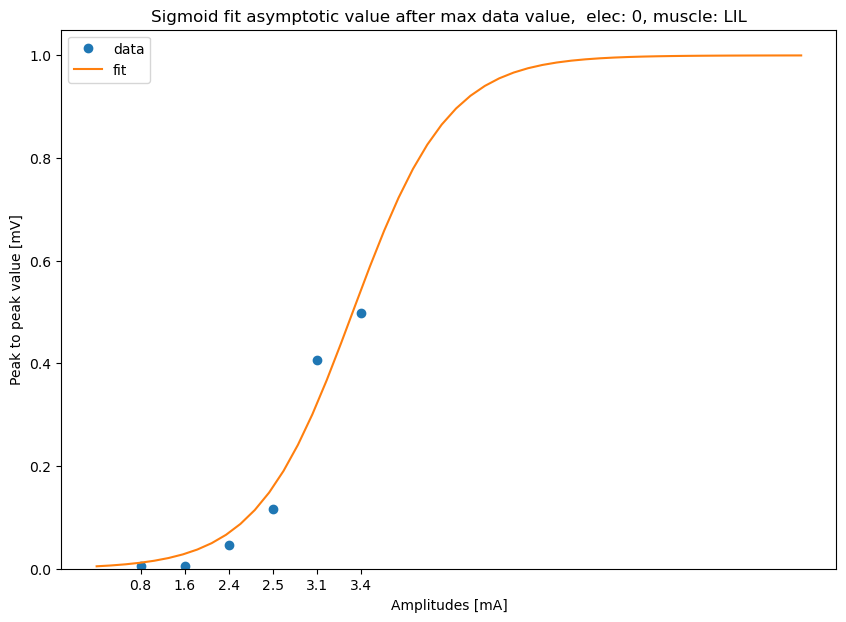

In [ ]:
# Neala version 


import numpy as np
import pylab
from scipy.optimize import curve_fit


data_structure= "max_P2P_div_amp"

def sigmoid(x, x0, k):
     y = 1 / (1 + np.exp(-k*(x-x0)))
     return y
# k>0

# Take slice of tensor and get rid of nan values
peak_peak_values=pd.DataFrame(peak2peak_data_to_tensor[muscle_i,elec_i,:,0,0]) #Convert tensor slice to df
peak_peak_values=peak_peak_values.dropna() #Get rid of nan values
peak_peak_values=np.array(peak_peak_values[0]) #Convert to np array
# Set values to plot for original data
xdata=np.arange(0, len(peak_peak_values)) 
ydata=peak_peak_values

# Set the given amplitudes as a x-label
amplitudes=pd.DataFrame(amplitude_filtereddata_to_tensor[muscle_i,elec_i,:])
amplitudes=amplitudes.dropna()
amplitudes=np.array(amplitudes[0])

# Find Optimal values for the parameters( popt) so that the sum of the squared residuals of f(xdata, *popt) - ydata is minimized.
popt, pcov = curve_fit(sigmoid, xdata, ydata)
print (popt)

# Set values to plot for interpolated data
x = np.linspace(-1, 15, 50) # How did I set this parameter ? 
y = sigmoid(x, *popt)

fig, ax = plt.subplots(figsize=(10,7))
plt.ylabel("Peak to peak value [mV]")
plt.xlabel("Amplitudes [mA]")
plt.title(f"Sigmoid fit asymptotic value after max data value,  elec: {elec_i}, muscle: {mt_muscles['muscle_name'][muscle_i]}")
ticks=np.arange(0, len(amplitudes))
labels=amplitudes
ax.set_xticks(ticks, labels=labels)

pylab.plot(xdata, ydata, 'o', label='data')
pylab.plot(x,y, label='fit')
pylab.ylim(0, 1.05)
pylab.legend(loc='best')

#Get original peak to peak, without dividing by amplitude, otherwise overfitting?
# ## Define Textbox
# axbox = fig.add_axes([0, 1.0, 1.0, 0.05]) #[left, bottom, width, height]
# text_box = TextBox(axbox,label=None, textalignment="center")
# text_box.set_val(f"Normalisation method: {data_structure}")  # Trigger `submit` with the initial string.

pylab.show()

## Evaluation preparation

### heat map

define which matrices to export for the evaluation

In [ ]:
dat=set_normalisation_by_max_response()

normalisation method is: normalise_max_response to df


In [ ]:
dat

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
LIL,0.609685,0.322656,0.009657,0.015873,0.272748,0.497428,0.591614,0.054155,0.008912,0.006803,0.006793,0.033635,0.012921,0.011674,0.182483,1.000000
RIL,0.064534,0.297731,0.018213,0.013978,0.021272,0.054375,0.061937,0.038113,0.015738,0.393835,0.225270,0.809293,1.000000,0.984585,0.321834,0.087891
LRF,0.330404,0.198652,0.013846,0.013758,0.869653,0.359235,0.244147,0.005030,0.009416,0.003196,0.004162,0.009912,0.006613,0.003183,0.628978,1.000000
RRF,0.004652,0.002978,0.004494,0.003776,0.002827,0.003990,0.004244,0.003661,0.017031,0.245206,0.429289,1.000000,0.160055,0.004751,0.445038,0.087838
LVL,0.009856,0.006134,0.007878,0.007500,0.710368,1.000000,0.008150,0.000710,0.006050,0.000743,0.000691,0.000793,0.000966,0.000838,0.368942,0.937400
RVL,0.000890,0.000799,0.001000,0.000546,0.000538,0.000672,0.000786,0.000712,0.012954,0.016708,0.095842,1.000000,0.023654,0.000669,0.079135,0.011426
LST,0.168887,0.088809,1.000000,0.927842,0.746032,0.129631,0.112218,0.012187,0.643867,0.004890,0.004791,0.017808,0.009596,0.004894,0.468434,0.432165
RST,0.000504,0.000381,0.000981,0.000363,0.000464,0.000466,0.000480,0.000336,0.602951,0.252588,0.810957,0.044998,0.016351,0.000475,1.000000,0.009083
LTA,0.028468,0.024747,1.000000,0.809476,0.190537,0.022907,0.027999,0.022858,0.244162,0.030310,0.020895,0.024036,0.020789,0.022447,0.048633,0.029629
RTA,0.008623,0.009489,0.010536,0.006443,0.008185,0.007789,0.008753,0.007188,0.361967,0.874765,0.944157,0.020490,0.006787,0.006425,1.000000,0.009889


In [ ]:
#between 0 and 1
matrix_muscles_df=set_normalisation_by_max_response()
matrix_muscles_df.to_csv('/Volumes/Extreme_SSD/Projectome_Estimation/evaluation_data/matrix_muscle_df.csv')

normalisation method is: normalise_max_response to df


In [ ]:
type(matrix_muscles_df)

pandas.core.frame.DataFrame

In [ ]:
matrix_muscles_df

elec_name,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
muscle_name,,,,,,,,,,,,,,,,
LIL,0.609685,0.322656,0.009657,0.015873,0.272748,0.497428,0.591614,0.054155,0.008912,0.006803,0.006793,0.033635,0.012921,0.011674,0.182483,1.000000
RIL,0.064534,0.297731,0.018213,0.013978,0.021272,0.054375,0.061937,0.038113,0.015738,0.393835,0.225270,0.809293,1.000000,0.984585,0.321834,0.087891
LRF,0.330404,0.198652,0.013846,0.013758,0.869653,0.359235,0.244147,0.005030,0.009416,0.003196,0.004162,0.009912,0.006613,0.003183,0.628978,1.000000
RRF,0.004652,0.002978,0.004494,0.003776,0.002827,0.003990,0.004244,0.003661,0.017031,0.245206,0.429289,1.000000,0.160055,0.004751,0.445038,0.087838
LVL,0.009856,0.006134,0.007878,0.007500,0.710368,1.000000,0.008150,0.000710,0.006050,0.000743,0.000691,0.000793,0.000966,0.000838,0.368942,0.937400
RVL,0.000890,0.000799,0.001000,0.000546,0.000538,0.000672,0.000786,0.000712,0.012954,0.016708,0.095842,1.000000,0.023654,0.000669,0.079135,0.011426
LST,0.168887,0.088809,1.000000,0.927842,0.746032,0.129631,0.112218,0.012187,0.643867,0.004890,0.004791,0.017808,0.009596,0.004894,0.468434,0.432165
RST,0.000504,0.000381,0.000981,0.000363,0.000464,0.000466,0.000480,0.000336,0.602951,0.252588,0.810957,0.044998,0.016351,0.000475,1.000000,0.009083
LTA,0.028468,0.024747,1.000000,0.809476,0.190537,0.022907,0.027999,0.022858,0.244162,0.030310,0.020895,0.024036,0.020789,0.022447,0.048633,0.029629


### Sigmoid

In [ ]:
muscles_popt_sigmoid_right=get_tensor_popt_per_combination(structure_class="muscles", side=0)
muscles_popt_sigmoid_right=get_tensor_popt_per_combination(structure_class="muscles", side=1)
roots_popt_sigmoid_right=get_tensor_popt_per_combination(structure_class="roots", side=0)
roots_popt_sigmoid_right=get_tensor_popt_per_combination(structure_class="roots", side=1)